<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/> 

# NIRSpec BOTS JWebbinar Notebook 2: Spec 2 
-----

**Author**: Nikolay Nikolov, AURA Associate Scientist, NIRSpec branch
<br>
**Pipeline Version**: 1.12.0 on November 8, 2023
<br>
**Last Updated**: version 1.12.5 on December 8, 2023

## Table of contents
1. [Introduction](#intro)<br>
   1.1. [Purpose of this Notebook](#purpose)<br>
   1.2. [Input Data](#inputs)<br>
2. [Setup](#setup)<br>
   2.1. [Python imports and environment variables](#imports)<br>
   2.2. [Data download and directory organization](#data)<br>
3. [A look at the input data - the `rateints` files](#look)<br>
4. [The JWST Stage 2 Pipeline `Spec2` and our custom steps](#spec2)<br>
   4.1. [Running the `Assign_wcs step` of the pipeline and obtaining the wavelength map](#awcs)<br>
        [Step 1: Obtain the wavelength map](#map)<br>
        [Step 2: Organize and check the data. Perform 2d spectral cutouts ](#cutouts)<br>
        [Step 3: Remove 1/f noise from the 2dcutouts](#1overf)<br>
        [Step 4: Identify and replace bad pixels](#bad)<br>
        [Step 5: Obtain centroid information using each 2D spectrum](#centroid)<br>
        [Step 6: Spectral tracing](#tracing)<br>
        [Step 7: Extract the spectra and obtain wavelength solution](#extraction)<br>
        [Step 8: Produce white and spectroscopic light curves and fitting data](#lcs)<br>
5. [Concluding remarks](#remarks)<br>

---

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

### 1.1.<font color='white'>-</font>Purpose of this Notebook<a class="anchor" id="purpose"></a> ###

In this notebook we provide an example to get started on the exploration and production of NIRSpec BOTS light curves. In particular, we focus on outputs from `Spec2` stage of the pipeline, and go through our own spectral centroiding, tracing and extraction procedures. The goal of this notebook is to produce white and spectroscopic lightcurves along with fitting products, which JWST NIRSpec BOTS users might want to perform on their datasets.

### 1.2<font color='white'>-</font>Input Data<a class="anchor" id="inputs"></a> ###

The input data for this notebook, a transit of WASP-39b observed in the BOTS G395H grism, are the `Detector1` `rateints` files. This full dataset can be found at https://stsci.box.com/s/r9k17tb2ig5vaivw6tvp52bupivo5wjv. The data set belongs to the <a href="https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1366">JWST Early Release Science program ERS-1366,</a> observation 3, and includes 456 integrations of 70 groups with the SUB2048 subarray, covering a total of 10.56 hours.

This notebook can be executed in two separate modes: 'process' and 'load'. Chosing the 'process' mode, the user can execute step-by-step and wait for the step to complete. Products created by the notebook will be saved. Selecting the 'load' mode would skip execution of the steps that take several tens of minutes to complete. Instead, the notebook will load pre-processed data. Finally, the notebook is designed to be run on both NRS1 and NRS2 data. The user needs to specify which detector wishes to analyze and execute all steps. 

2.<font color='white'>-</font>Setup <a class="anchor" id="setup"></a>
------------------

### 2.1.<font color='white'>-</font>Python imports and environment variables<a class="anchor" id="imports"></a> ###

In this section we set a number of necessary things in order for the pipeline to run successfully.

First we'll set the CRDS context; this dictates the versions of various pipeline reference files to use. 

Next we'll import the various python packages that we're actually going to use in this notebook, including both generic utility functions and the actual pipeline modules themselves. Make sure to install the jwst pipeline, astropy, opencv-python and tqdm. 

Finally, we also define three directories: 
1. `working_folder` - where this notebook is placed, and where the remaining two directories will live.
2. `spec2_input` - a directory that will contain the rateints (slope) files
3. `spec2_results` - a directory with the pre-processed data from each step. 


In [50]:
# This cell is needed when running from the Science Platform to pre-load some cache data
import shutil
import os

CRDS_PATH='/home/jovyan/crds_cache/'
CRDS_SERVER_URL='https://jwst-crds.stsci.edu'

# Copy the pre-loaded data into local writable folder
working_folder = os.getcwd()+'/'
spec2_results = working_folder + 'spec2_results/'
print(spec2_results)
if not os.path.exists(spec2_results):
    os.makedirs(spec2_results)
shutil.copytree('/home/shared/preloaded-fits/jwebbinar_29/JWebbinar2023-TSO/spec2_results/', spec2_results,dirs_exist_ok=True)

# Set Paths
spec2_input = '/home/shared/preloaded-fits/jwebbinar_29/JWebbinar2023-TSO/spec2_input/'
spec2_results = working_folder + 'spec2_results/'


/home/jovyan/jwebbinar_29/spec2_results/


In [2]:
# Need to set these enviromental variables for this notebook to work properly:
%set_env CRDS_PATH $CRDS_PATH
%set_env CRDS_SERVER_URL $CRDS_SERVER_URL


# General functions
import os
import time as tt
import pickle
import cv2

# Python math functions
import numpy as np
from numpy.polynomial import chebyshev
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d, splrep,splev

# Plot functions
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Astropy and other spectroscopy utilities
import astropy
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.io import fits, ascii
from astropy.modeling import models, fitting
from astropy.modeling.models import Gaussian1D
from astropy.table import Table
from astropy.time import Time

from astropy.io import fits
import astropy.io.fits as fits
from astropy.timeseries import LombScargle
from astropy.utils.data import download_file

# JWST Pipeline
from jwst import datamodels
from jwst.pipeline import calwebb_spec2
from jwst.assign_wcs import nirspec
from jwst.assign_wcs import AssignWcsStep

# Python utility functions task progress tracker
from tqdm import tqdm

import crds
import json


# Define the folder on which we will be working on (here we'll store all our outputs):
#working_folder = os.getcwd()+'/'
#spec2_input = os.getcwd()+'/spec2_input/'
#spec2_results = working_folder + 'spec2_results/'

# if not os.path.exists(spec2_input):
#     os.makedirs(spec2_input)
    
# if not os.path.exists(spec2_results):
#     os.makedirs(spec2_results)

env: CRDS_PATH=/home/jovyan/preloaded-crds/
env: CRDS_SERVER_URL=https://jwst-crds.stsci.edu


In [3]:
print(working_folder)
print(spec2_input)
print(spec2_results)

/home/jovyan/jwebbinar_29/
/home/shared/preloaded-fits/jwebbinar_29/JWebbinar2023-TSO/spec2_input/
/home/jovyan/jwebbinar_29/spec2_results/


### 2.2.<font color='white'>-</font>Data download and directory organization<a class="anchor" id="data"></a> ###

This notebook will create 'spec2_input' and 'spec2_results' folders to store the input data and results from the individual steps detailed below. Folder 'spec2_input' contains the rateints data needed to start the notebook. Directory 'spec2_results' contains pre-processed data products, results from each step run at the creation of the notebook. The purpose of this directory is to provide the user with pre-processed data of the time consuming steps.

**Note**: Please, download the needed data from https://stsci.box.com/s/r9k17tb2ig5vaivw6tvp52bupivo5wjv by clicking on the link. A new window will be loaded in your browser. Identify a tab with three dots (More Options), click on it and select download. The data size is ~1.7GB and takes ~5 minutes to download. Once downloaded, please enter the 'JWebbinar2023-TSO' directory and move the directories 'spec2_input' and 'spec2_results' one level up i.e., in the same directory, where this notebook is saved. The empty directory 'JWebbinar2023-TSO' can optionally be deleted. Alternatively, one can simply select the two folders for download individually from box.


In [4]:
#----------------------------------------
# Data and file configuration step
#----------------------------------------

# Choose a run mode with two options: 
#    process - processes the data (takes several tens of minutes)
#    load - reads pre-processed data (all data will be downloaded if not present)
run_mode = 'load' #
process_detector = 'nrs1' # choose 'nrs1', 'nrs2'

# Define the rateints files (aka slope or rate images)
if process_detector == 'nrs1':
    files = ['jw01366003001_04101_00001-seg001_nrs1_rateints.fits',
             'jw01366003001_04101_00001-seg002_nrs1_rateints.fits',
             'jw01366003001_04101_00001-seg003_nrs1_rateints.fits']

if process_detector == 'nrs2':
    files = ['jw01366003001_04101_00001-seg001_nrs2_rateints.fits', 
             'jw01366003001_04101_00001-seg002_nrs2_rateints.fits',
             'jw01366003001_04101_00001-seg003_nrs2_rateints.fits']


#----------------------------------------

preprocessed_file_names = ['_step_01_wavelength_map.pickle',
                           '_step_02_spectra2D_cutouts.pickle',
                           '_step_03_spectra2D_1overf.pickle',
                           '_step_04_nominal_psf_correction.pickle',
                           '_step_05_centroiding.pickle',
                           '_step_06_spectral_trace.pickle',
                           '_step_07_spectra1D.pickle',
                           '_step_08_light_curves.pickle']


Extract data file root names. These are needed in the remaining of the notebook for data read.

In [5]:
froot = [files[i].replace('rateints.fits', '') for i in range(len(files))]
print(froot)

['jw01366003001_04101_00001-seg001_nrs1_', 'jw01366003001_04101_00001-seg002_nrs1_', 'jw01366003001_04101_00001-seg003_nrs1_']


3.<font color='white'>-</font>A look at the input data - the `rateints` files<a class="anchor" id="look"></a>
------------------

The `rateints` files contain the slope images for each integration, which is the product we want to use for our BOTS analysis. Let's take a look at the contents of the first segment file using the JWST datamodels.

<CubeModel(155, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_rateints.fits>
root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.15.1
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): fcc40886bc4f9d9d7b4a4c72c6d2ce39c72b960fb85fba1aa16a75d0bd5a456f
├─data (ndarray): shape=(155, 32, 2048), dtype=float32
├─dq (ndarray): shape=(155, 32, 2048), dtype=uint32
├─err (ndarray): shape=(155, 32, 2048), dtype=float32
├─int_times (FITS_rec): shape=(155,), dtype=void416
├─meta (dict)
│ ├─aperture (dict) ...
│ ├─bunit_data (str): DN/s
│ ├─bunit_err (str): DN/s
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ ├─calibration_software_version (str): 1.12.0
│ └─31 not shown
├─var_poisson (ndarray): shape=(155, 32, 2048), dtype=float32
└─var_rnoise (ndarray): shape=(155, 32, 2048), dtype=float32
Some nodes not shown.


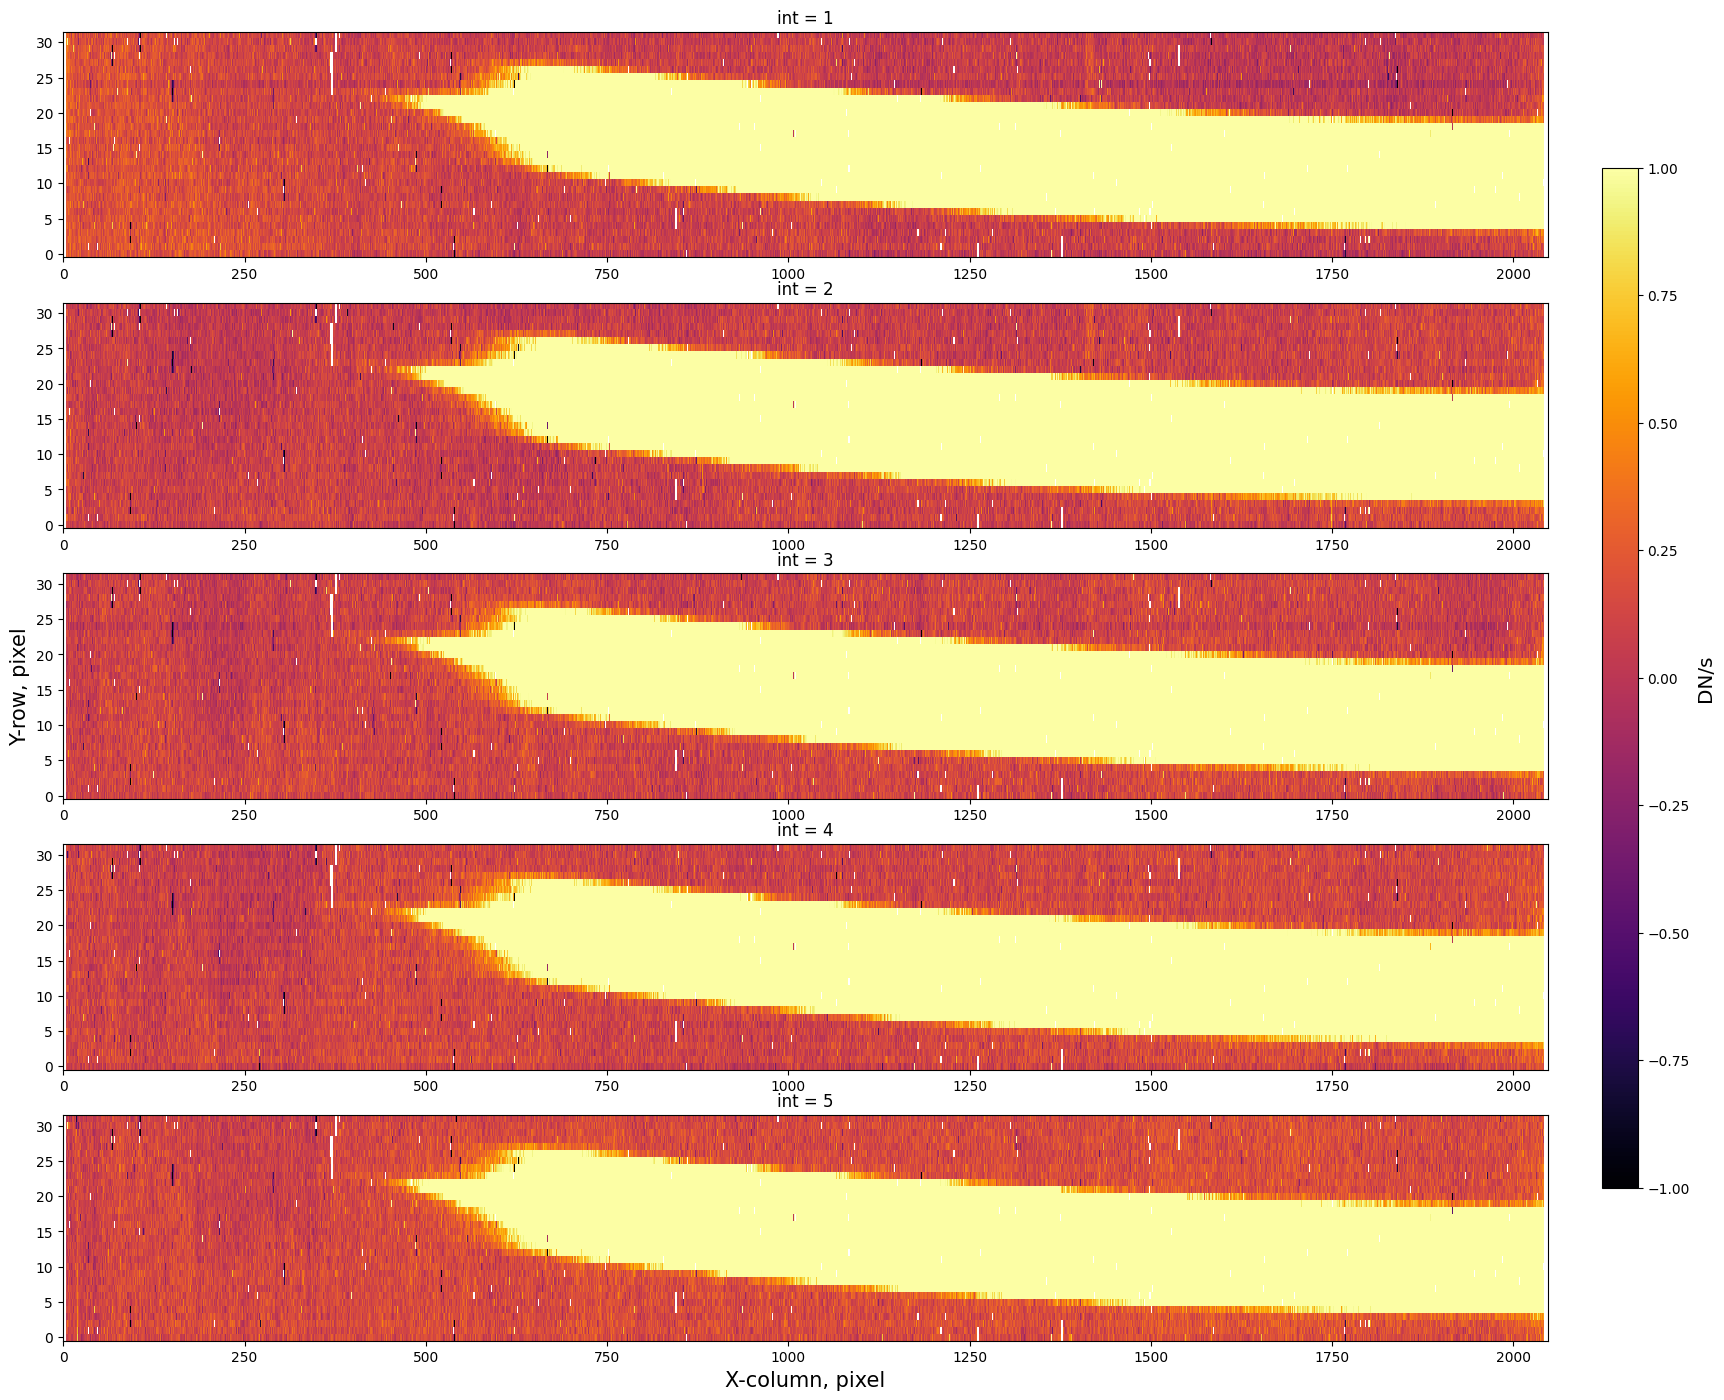

In [6]:
rate_ints = datamodels.open(spec2_input + files[0])
print(rate_ints)

# Print the file inventory
rate_ints.info()


# Let's plot five integrations from the data cube and see how the data looks like

# Define the range for the colorbar of the plot
if process_detector == 'nrs1':
    f_lo = -1 # lower limit for flux
    f_hi = +1# upper limit for flux

if process_detector == 'nrs2':
    f_lo = -1 # lower limit for flux
    f_hi = +1# upper limit for flux


sl_fig, axs = plt.subplots(ncols=1, nrows=5, figsize=[18, 17])

for i, ax in enumerate(axs.flat):
    im = ax.imshow(rate_ints.data[i, :, :], 
                   origin='lower', 
                   aspect='auto', 
                   interpolation='none',
                   cmap='inferno', 
                   clim=(f_lo, f_hi))
    if i == 2:
        ax.set_ylabel('Y-row, pixel', fontsize=15)
    ax.set_title('int = {0}'.format(i+1))

ax.set_xlabel('X-column, pixel', fontsize=15)
sl_fig.subplots_adjust(right=0.95)
cbar_ax = sl_fig.add_axes([0.98, 0.2, 0.02, 0.6])
cbar = sl_fig.colorbar(im, cax=cbar_ax)
cbar.set_label('DN/s', fontsize='x-large')


### <font color='white'>-</font>4. The JWST Stage 2 Pipeline `Spec2` and our custom steps<a class="anchor" id="spec2"></a>

In Stage 2 of the pipeline, the following calibrations are applied to the NIRSpec BOTS data:

1. Assigning a world coordinate system WCS for images and wavelength map for spectra -- WILL BE RUN
3. Extracting 2d spectral ctouts -- WILL BE SKIPPED WITH OUR WORK AROUND
4. Flat fielding -- WILL BE SKIPPED
5. Assigning a source type -- WILL BE SKIPPED
6. Photometric calibration -- WILL BE SKIPPED
7. Pixel replace  -- WILL BE SKIPPED WITH OUR WORK AROUND
8. Resampling spectrum -- WILL BE SKIPPED
9. Spectral extraction  -- WILL BE SKIPPED WITH OUR WORK AROUND

In what follows, we will be running the first step of the pipeline, and provide the necessary additional steps outside of the pipeline with the goal to produce white and spectroscopic light curves and complementary data for detrending light curves.


### <font color='white'>-</font>4.1. Running the `Assign_wcs step` of the pipeline and obtaining the wavelength map<a class="anchor" id="awcs"></a>


The role of this step is to attach world coordinate system information to the data in a new extension called WCS. By doing so, every pixel in the detector array has an associated RA, Dec and wavelength. In addition, the step also defines a bounding box region over which these values are defined with NaNs everywhere else, owing to the current limitations of calibration data.

**NOTE**. The assignment of wavelength values to pixels assumes that the target is placed at a specific location, i.e. the nominal pointing location for the employed subarray. The WATA acquisition procedure should be capable of placing the target there with an accuracy of < 10 mas, and an image will be taken through the WATA filter, which is accessible along with the data to verify the source positioning. For reference, 1 pixel corresponds to 0.1 arcsec for NIRSpec, or the accuracy of positioning the target on the detecor should be 0.1 pixel. 

Importantly, offsets of the target from its nominal position can cause small offset of the spectrum on the detector. Causes for TA offsets include inaccurate target coordinates, saturated pixels and signal to noise lower than ~20.


The next cell runs this the awcs step for all files. Let's also measure how much time it takes to run on this computer.

In [7]:
import time as tt
from jwst.assign_wcs import AssignWcsStep


start = tt.time()

# There is no need to specify the detector identifier, because it is in the file names and the pipeline will use it from there.

for i in range(len(files)):
    AssignWcsStep.call(spec2_input + files[i], output_dir = spec2_results, save_results = True, skip = False)


end = tt.time()
print("Run time: ", round(end-start,1), " sec")


2023-12-13 15:40:45,279 - CRDS - INFO -  Fetching  /home/jovyan/preloaded-crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 186 files) (0 / 628.1 K bytes)
2023-12-13 15:40:45,477 - CRDS - INFO -  Fetching  /home/jovyan/preloaded-crds/mappings/jwst/jwst_system_calver_0035.rmap    4.4 K bytes  (2 / 186 files) (694 / 628.1 K bytes)
2023-12-13 15:40:45,639 - CRDS - INFO -  Fetching  /home/jovyan/preloaded-crds/mappings/jwst/jwst_system_0034.imap      385 bytes  (3 / 186 files) (5.1 K / 628.1 K bytes)
2023-12-13 15:40:48,782 - CRDS - INFO -  Fetching  /home/jovyan/preloaded-crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 186 files) (5.5 K / 628.1 K bytes)
2023-12-13 15:40:51,907 - CRDS - INFO -  Fetching  /home/jovyan/preloaded-crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 186 files) (6.9 K / 628.1 K bytes)
2023-12-13 15:40:55,027 - CRDS - INFO -  Fetching  /home/jovyan/preloaded-crds/mappings/jwst/jwst_nirspec_sup

Run time:  51.3  sec


OK, the step ran nicely taking just 4 seconds, and saved the output in the `spec2_results` directory. We continue with our custom steps below, which we will call Steps 1 to 7. We will save the results from each step in a pickle file, and will plot results in the notebook.

# <font color='white'>-</font>Step 1: Obtain the wavelength map<a class="anchor" id="map"></a>

Now let's load the awcs data inside a JWST datamodel and obtain the wavelength map. This step takes about 9min to run.

It should be noted that the cell below refers only to NIRSpec data, and not data from all JWST instruments. The reason for that is that NIRSpec requires an extra step that specifies which slit should be used to obtain the wavelength map. This step is the following: 


In [8]:
from jwst import assign_wcs
from gwcs import wcstools

# Open the awcs step as JWST data model for the first segment
awcs = datamodels.open(spec2_results + froot[0] + 'assignwcsstep.fits')

# Specify the slit identifier using the metadata; it should be S1600A1 for BOTS
print('Obtaining wavelength solution using slit:', awcs.meta.instrument.fixed_slit)
wcs_out = assign_wcs.nrs_wcs_set_input(awcs, awcs.meta.instrument.fixed_slit)

# Get the output wavelength map from the bounding box along with bounding box coordinates. Define bounding box depending on the 
# subarray size (by default, wcs_out maps the slit in the detector for NIRSpec)
wcs_out.bounding_box = ( (-0.5, awcs.data.shape[2]-0.5), 
                         (-0.5, awcs.data.shape[1]-0.5) 
                       )   
#print(wcs_out)

# Obtain bounding box data
bb_columns, bb_rows = wcstools.grid_from_bounding_box( wcs_out.bounding_box )
_, _, bb_wavelength_map = wcs_out(bb_columns, bb_rows)

# Prepare and fill wavelength map given this bounding box (fill the rest with nans because later nans are ommited):
wavelength_map = np.full([ awcs.data.shape[1], awcs.data.shape[2] ], np.nan)

# Obtain the wavelength map
for i in range( bb_wavelength_map.shape[0] ):
    for j in range( bb_wavelength_map.shape[1] ):
            wavelength_map[int(bb_rows[i, j]), int(bb_columns[i, j])] = bb_wavelength_map[i, j]

Obtaining wavelength solution using slit: S1600A1


Pickle the wavelength solution, so we don't need to reobtain it every time.

In [9]:

wave_map = {'wavelength_map':wavelength_map}

print('\nSvaing ' + process_detector + preprocessed_file_names[0] + '.')
pickle_out = open( spec2_results + '/' + process_detector + preprocessed_file_names[0], 'wb')
pickle.dump(wave_map, pickle_out)
pickle_out.close()



Svaing nrs1_step_01_wavelength_map.pickle.


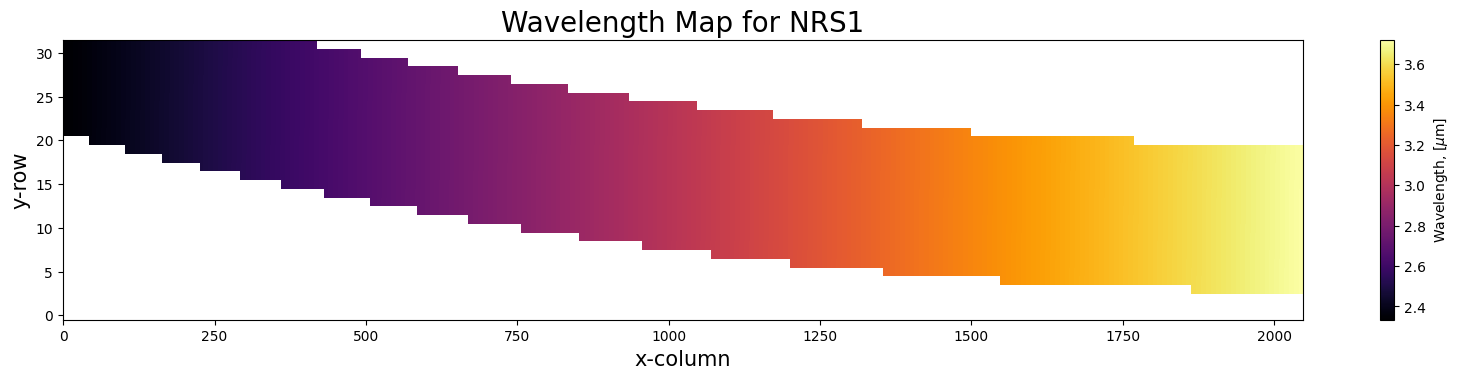

2048 32


In [10]:
# Plot the map

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('Wavelength Map for ' + process_detector.upper(), fontsize=20)
im1 = plt.imshow(wavelength_map, 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower')

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Wavelength, [$\mu$m]')

plt.show()

print(len(wavelength_map[0,:]),len(wavelength_map[:,0]))


The wavelength map on the plot covers the location, where the spectrum is imaged by the detector. The empty plot area has pixel values set to nans, owing to missing calibration data. We will come back to this wavelength map when we have the extracted one dimensional spectra and will use it to assign a wavelength data for the spectra. Let's continue with the next step.

# <font color='white'>-</font>Step 2: Organize and check the data. Perform 2d spectral cutouts <a class="anchor" id="cutouts"></a>

The goal of this step is to cut unnecessary pixels from the two-dimesional spectra. This saves computational time and trims data that will not be utilized. To perform the step, we would first load the science extensions for all integrations, covered by the three segments of the WASP-39b observation and put them in one big array. We will also do this for the error and data quality arrays, and time stamps using the slope images from the `AWCS` step. This would make handling the data easier throughout the notebook. Keep in mind that such approach has the potential to run in data memory issues for data sets with large number of integrations (e.g., bright sources with small number of groups), in case you decide to adapt this notebook. Tips for such cases: combine only a few segments, or analyze each segment separately. 

In [11]:
n_segments = len(froot)
print('Number of segments: ', n_segments)

for i in range(n_segments):
    print('\nConcatenating segment ', i+1, ' out of ', n_segments)
    ramp_HDUL = datamodels.open(spec2_results + froot[i] + 'assignwcsstep.fits')
    #ramp_HDUL.info() # Use this command if you wish to take a look at the data model contents
    ramp_sci = ramp_HDUL.data
    ramp_err = ramp_HDUL.err
    ramp_DQs = ramp_HDUL.dq
    times    = ramp_HDUL.int_times.int_mid_BJD_TDB
    print('Number of time stamps per segment: ', len(times))

    # Concatenate the data from each segment into the large arrays
    if i == 0:
        all_spec    = ramp_sci
        all_err     = ramp_err
        all_DQs     = ramp_DQs
        all_times   = times
    if i > 0:
        all_spec    = np.concatenate((all_spec,    ramp_sci), axis = 0)
        all_err     = np.concatenate((all_err,     ramp_err), axis = 0)
        all_DQs     = np.concatenate((all_DQs,     ramp_DQs), axis = 0)
        all_times   = np.concatenate((all_times,   times))
    ramp_HDUL.close()

print('\nDimensions of the concatenated array: ')
print('number of images: ', len(all_spec[:,0,0]))
print('x-size: ', len(all_spec[0,0,:]))
print('y-size: ', len(all_spec[0,:,0]))
print('Number of time stamps: ', len(all_times))



Number of segments:  3

Concatenating segment  1  out of  3
Number of time stamps per segment:  155

Concatenating segment  2  out of  3
Number of time stamps per segment:  155

Concatenating segment  3  out of  3
Number of time stamps per segment:  155

Dimensions of the concatenated array: 
number of images:  465
x-size:  2048
y-size:  32
Number of time stamps:  465


Let's check the time stamps for any issues. If there are no problems, the time stamps from each segment will align in one continuous line. In case of issues, we would see jumps, and/or differences in the slopes from each segment.

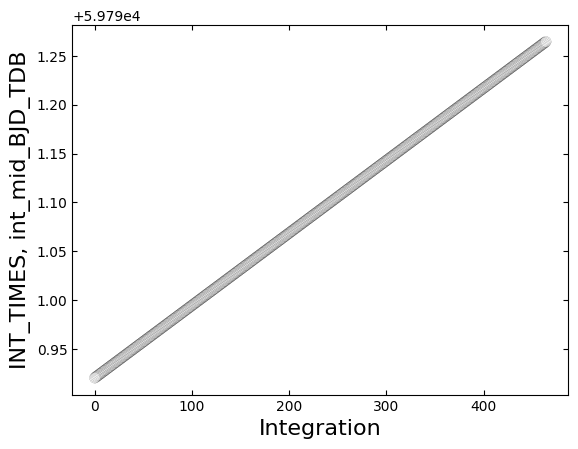

In [12]:
# Check times
int_t = np.arange(len(all_times))

from pylab import rcParams
fig, ax = plt.subplots()
#plt.rcParams.update({'font.sans-serif':'Helvetica'})

rcParams['figure.figsize'] = [7, 5]           # Figure dimensions
rcParams['image.aspect']   = 1                     # Aspect ratio

ax.tick_params(direction='in', axis='both', which='both', top='on', bottom='on', right='on', left='on')
sc = plt.scatter(int_t, all_times,  s=60, edgecolors="black", facecolors='none', linewidth=0.1)

ax.set_xlabel('Integration', fontsize=16)
ax.set_ylabel('INT_TIMES, int_mid_BJD_TDB', fontsize=16)
plt.show()

# If you need to save the plot, just uncomment the code below.
#pp = PdfPages(results_dir + '/JDvInd.pdf')
#plt.savefig(pp,format='pdf',bbox_inches='tight',pad_inches=0.05, dpi=250)
#pp.close()
#clf()


All looks good!
Let's move to the 2d cutouts. First we will plot one spectrum and decide where do we want to cut.

650 2033


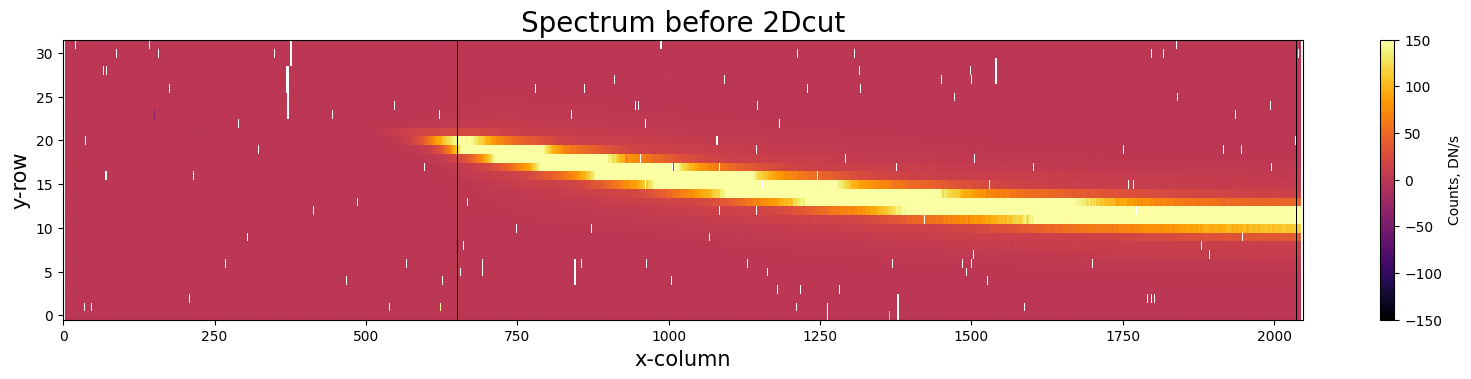

In [13]:
# Plot a 2D spectrum
if process_detector == 'nrs1':
    int_id  = 20 # select an integration to show
    f_lo    = -150 # lower limit for flux
    f_hi    = +150# upper limit for flux
    
    # Define cutout
    xcut_low  = 650
    xcut_high = all_spec.shape[2] - 15
    print(xcut_low, xcut_high)

if process_detector == 'nrs2':
    int_id  = 20 # select an integration to show
    f_lo    = -150 # lower limit for flux
    f_hi    = +150# upper limit for flux
    
    # Define cutout
    xcut_low  = 4
    xcut_high = all_spec.shape[2] - 25
    print(xcut_low, xcut_high)


image_for_inspection = all_spec[int_id,:,:]
image_for_inspection[:,xcut_low+1]  = -999.
image_for_inspection[:,xcut_high+1] = -999.
image_for_inspection[:,xcut_high+2] = -999.


plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('Spectrum before 2Dcut', fontsize=20)
im1 = plt.imshow(image_for_inspection, 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower',
                 clim=(f_lo, f_hi))

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Counts, DN/s')

plt.show()

Next, we need to just trim the unnecessary data and plot again to check how the cutouts look.

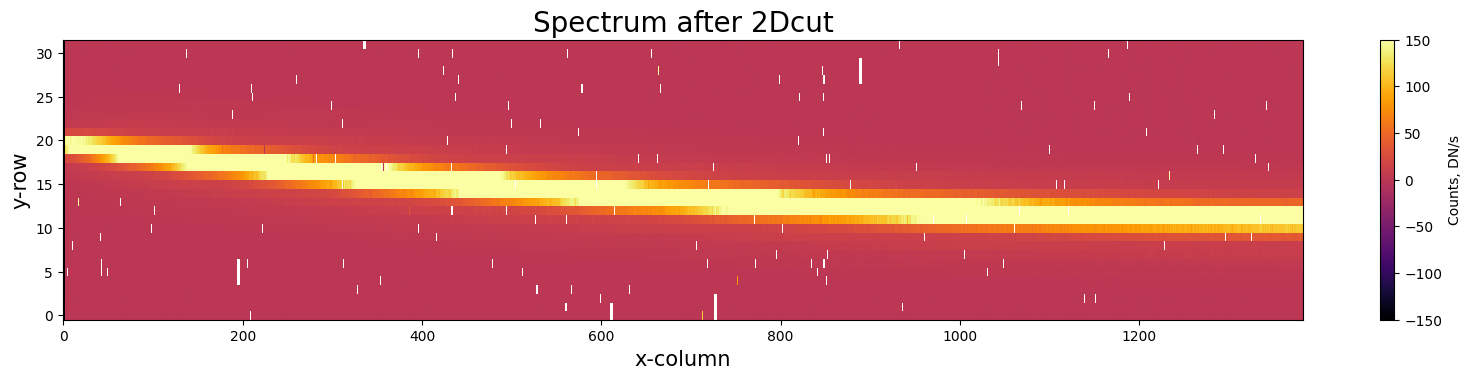

In [14]:
# Perform cutouts of the 2d spectra and wavelength map

all_spec = all_spec[:,:,xcut_low:xcut_high]
all_err  = all_err[:,:,xcut_low:xcut_high]
all_DQs  = all_DQs[:,:,xcut_low:xcut_high]
wavelength_map = wavelength_map[:,xcut_low:xcut_high]

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('Spectrum after 2Dcut', fontsize=20)
im1 = plt.imshow(all_spec[int_id,:,:], 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower',
                 clim=(f_lo, f_hi))

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Counts, DN/s')


spec_xlen = len(all_spec[0,0,:])
spec_ylen = len(all_spec[0,:,0])
nint      = len(all_spec[:,0,0])

plt.show()

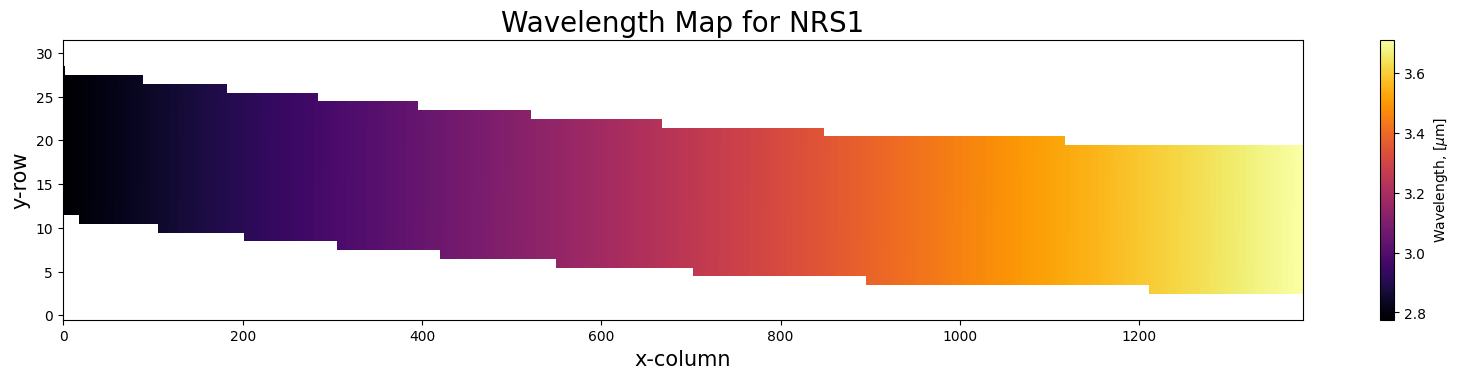

In [15]:

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('Wavelength Map for ' + process_detector.upper(), fontsize=20)
im1 = plt.imshow(wavelength_map, 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower')

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Wavelength, [$\mu$m]')
plt.show()

In [16]:

# Pickle the 2D cutouts, so we don't have to run this step every time
if (run_mode == 'process'):
    print('\nSvaing ' + process_detector + preprocessed_file_names[1] + '.')
    
    spectra2D_cutouts = {\
    'all_spec':all_spec, \
    'all_err':all_err, \
    'all_DQs':all_DQs, \
    'all_times':all_times, \
    'nint':nint, \
    'spec_xlen':spec_xlen, \
    'spec_ylen':spec_ylen, \
    'wavelength_map': wavelength_map
    }
    
    pickle_out = open( spec2_results + '/' + process_detector + preprocessed_file_names[1], 'wb')
    pickle.dump(spectra2D_cutouts, pickle_out)
    pickle_out.close()
    

In [17]:

# Read the pickle file with the 2D cutouts
if (run_mode == 'load'):
    pickle_in = open( spec2_results + process_detector + preprocessed_file_names[1], 'rb')
    
    spectra2D_cutouts = pickle.load( pickle_in )
    pickle_in.close() # close the file
    
    print('Showing the pickled data:')
    
    cnt = 0
    for item in spectra2D_cutouts:
        print('The data ', cnt, ' is : ', item)
        cnt += 1
    
    all_spec = spectra2D_cutouts['all_spec']
    all_err = spectra2D_cutouts['all_err']
    all_DQs = spectra2D_cutouts['all_DQs']
    all_times = spectra2D_cutouts['all_times']
    nint = spectra2D_cutouts['nint']
    spec_xlen = spectra2D_cutouts['spec_xlen']
    spec_ylen = spectra2D_cutouts['spec_ylen']
    wavelength_map = spectra2D_cutouts['wavelength_map']


Showing the pickled data:
The data  0  is :  all_spec
The data  1  is :  all_err
The data  2  is :  all_DQs
The data  3  is :  all_times
The data  4  is :  nint
The data  5  is :  spec_xlen
The data  6  is :  spec_ylen
The data  7  is :  wavelength_map


# <font color='white'>-</font>Step 3: Remove 1/f noise from the 2dcutouts <a class="anchor" id="1overf"></a>


JWST detector readout electronics (aka SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. When using NIRSpec BOTS, this 1/f noise appears as vertical banding that spans the entire width of the 2d spectral image, and varies from column to column. If not handled properly, the 1/f noise can introduce systematic errors and extra scatter in the light curves. For more information, please visit: <a href="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#JWSTTimeSeriesObservationsNoiseSources-1/fnoise">JWST Time-Series Observations Noise Sources.</a>

One way to remove 1/f noise for the BOTS data can be done by measuring the median count level of a column using pixels outside of the Point Spread Function (PSF). This median flux is then subtracted from the entire column. The function below performs this task for a given image using backreound region above and below the spectrum. 

In [18]:
def correct_one_over_f(image, blow, bhigh, detector_id):
    # Inputs:
    # image - image to correct, 2D array
    # blow - lower column pixels for the two regions, a tuple of two values 
    # bhigh - higher column pixels for the two regions, a tuple of two values

    y_lo_1, y_lo_2 = blow
    y_hi_1, y_hi_2 = bhigh
    
    corrected_image = np.copy(image)
    for i in range(image.shape[1]):
        #print(image.shape[1])
        
        if (detector_id == 'nrs1'):
            corrected_image[:, i] -= np.nanmedian( np.concatenate((corrected_image[y_lo_1:y_hi_1,i],corrected_image[y_lo_2:y_hi_2,i])) )

        if (detector_id == 'nrs2'):
            if (i <= 1250):
                corrected_image[:, i] -= np.nanmedian( corrected_image[y_lo_1:y_hi_1,i] )
            if (i > 1250):
                corrected_image[:, i] -= np.nanmedian( corrected_image[y_lo_2:y_hi_2,i] )

    return corrected_image      

In [19]:
# First, define the background regions for each detector

if process_detector == 'nrs1':
    blow  = (0, 26)
    bhigh = (5, 31)

if process_detector == 'nrs2':
    blow  = (26, 0)
    bhigh = (31, 5)

corrected_1overf_2Dspec = np.copy(all_spec)

#print(len(corrected_rampfit_results[0,:,0]))


for i in tqdm(range(len(all_spec[:,10,10]))):
    corrected_1overf_2Dspec[i, :, :] = correct_one_over_f( all_spec[i, :, :], blow, bhigh, process_detector )


100%|██████████| 465/465 [00:19<00:00, 24.31it/s]


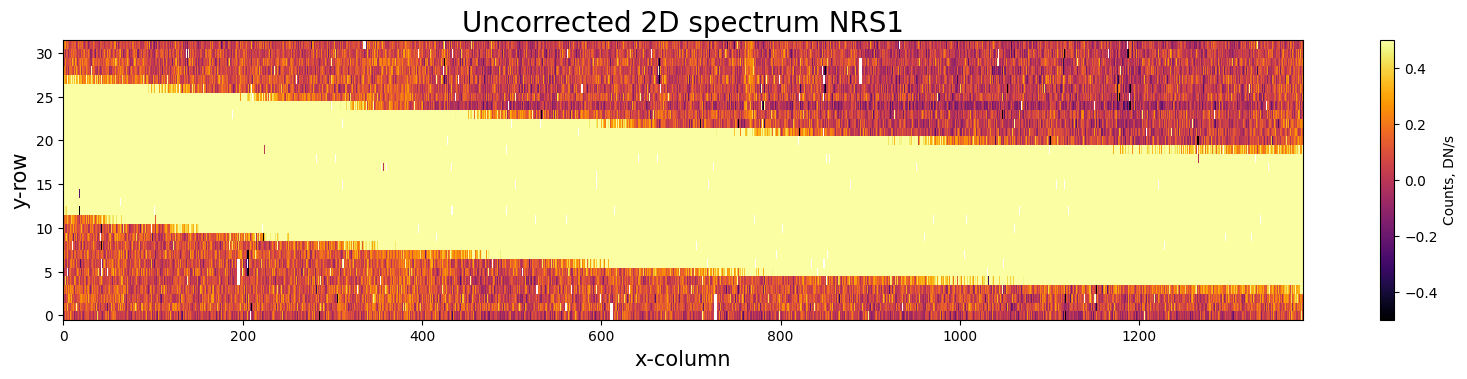

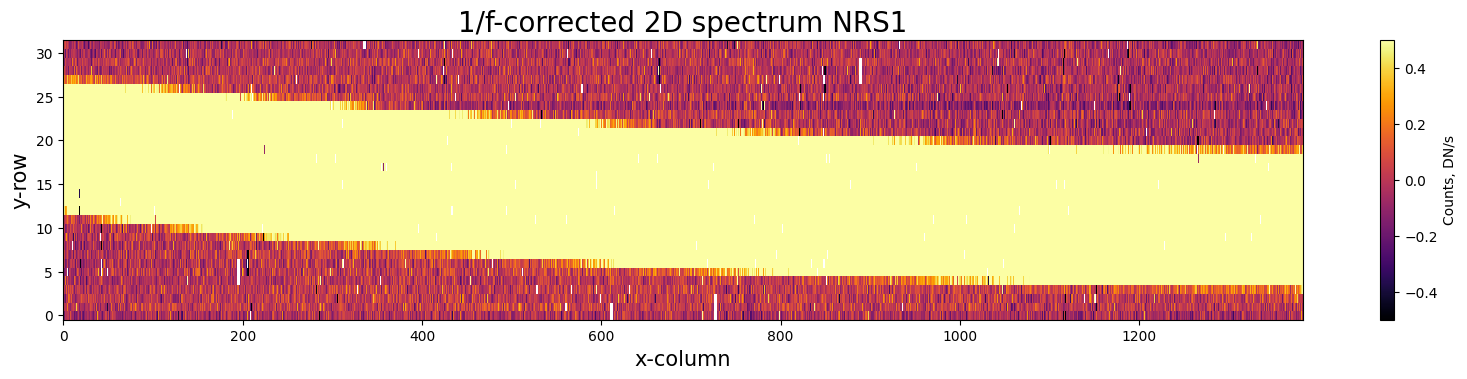

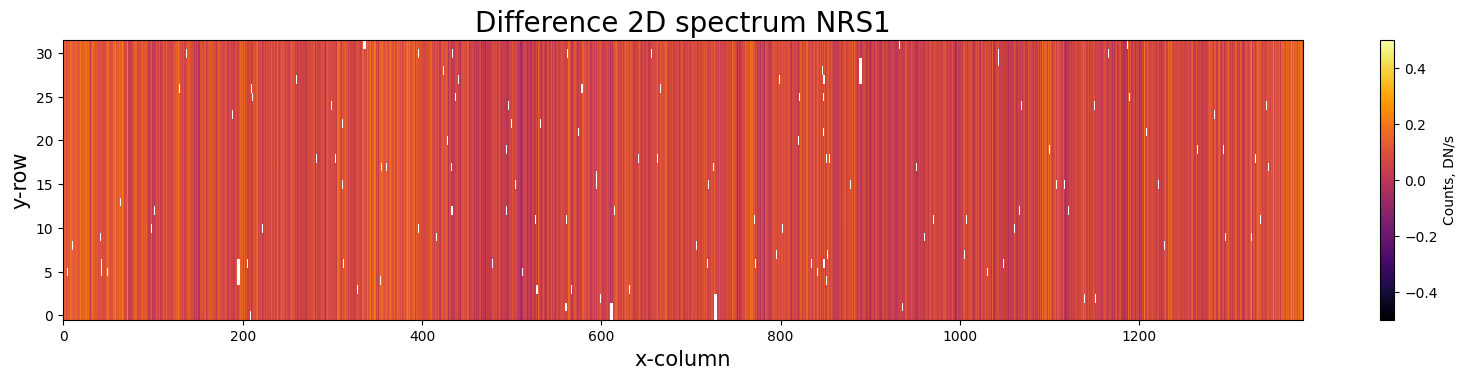

In [20]:


if process_detector == 'nrs1':
    int_id  = 0 # select an integration to show
    f_lo = -0.5 # lower limit for flux
    f_hi = +0.5 # upper limit for flux

if process_detector == 'nrs2':
    int_id  = 0 # select an integration to show
    f_lo = -0.5 # lower limit for flux
    f_hi = +0.5 # upper limit for flux

# Plot the original uncorrected image
plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('Uncorrected 2D spectrum ' + process_detector.upper(), fontsize=20)
im1 = plt.imshow(all_spec[int_id,:,:], 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower',
                 clim=(f_lo, f_hi))

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Counts, DN/s')




# Plot the corrected image
plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('1/f-corrected 2D spectrum ' + process_detector.upper(), fontsize=20)
im1 = plt.imshow(corrected_1overf_2Dspec[int_id,:,:], 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower',
                 clim=(f_lo, f_hi))

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Counts, DN/s')



# Plot the difference image
plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('Difference 2D spectrum ' + process_detector.upper(), fontsize=20)
im1 = plt.imshow(all_spec[int_id,:,:] - corrected_1overf_2Dspec[int_id,:,:], 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower',
                 clim=(f_lo, f_hi))

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Counts, DN/s')

plt.show()

In [21]:
# Pickle the 2D cutouts, so we don't have to run this step every time
print('\nSvaing ' + process_detector + preprocessed_file_names[2] + '.')
    
spectra2D_1overf = {\
'corrected_1overf_2Dspec':corrected_1overf_2Dspec
}

pickle_out = open( spec2_results + '/' + process_detector + preprocessed_file_names[2], 'wb')
pickle.dump(spectra2D_1overf, pickle_out)
pickle_out.close()
    


Svaing nrs1_step_03_spectra2D_1overf.pickle.


# <font color='white'>-</font>Step 4: Identify and replace bad pixels <a class="anchor" id="bad"></a>

A visual inspection of the 2D spectra reveals several isolated bright and dark pixels. Some of these pixels can be intrinsic cosmic rays, or snow balls, but in their majority these are bad e.g., hot or dead pixels. JWST data has flags that define such pixels. 

We can leave these pixels and continue our analysis. However, when it comes to centroiding and tracing the spectra, it is better to assign some values to these bad pixels, because they can confuse the fit for the centroid. In the step below, we will identify and replace these pixels. To do that, we will iterate over each column, identify bad pixels using the data quality extension for each integration and replace the bad pixels. The replacement will be done using a representative PSF profile, aka nominal PSF profile. It is constructed using the data by median combining a few adjacent columns that preceed and follow the column of inspection during the iteration. This method has been detailed in <a href="https://ui.adsabs.harvard.edu/abs/2014MNRAS.437...46N/abstract">Nikolov et al. (2014).</a>

In a second pass, we will take the difference between the nominal PSF profile and the relevant column. We will inspec the difference column for 3 sigma outliers and correct their values with the nominal PSF profile. This step would identify pixels that significantly deviate from the rest, but have not been identified and included in the data quality flags as bad/hot pixels.

In [22]:
def nominal_psf_prof(spec2D):
    # Computes a nominal PSF profile for a 2D spectrum using median
    # For best results: provide a few columns before and after e.g., 3-before and 3-after (6) 
    # the column for which a nominal PSF profile is needed
    nominal_profile = np.nanmedian(spec2D, axis=1)
    #print(nominal_profile)
    return nominal_profile

#nm_pr = nominal_psf_prof(all_spec[0,:,180:220])
#print('nm_pr ', nm_pr, 'len ', len(nm_pr))


def idx_for_nominal_psf_prof(row_id, xsize2Dspec, edge_min):
    # Determines the column indexes to be used in the function nominal_psf_prof
    # Input:
    #       row_id - row index for which pixels for the nominal PSF profiles need to be determined
    #       xsize2Dspec - size of the full two dimensional spectrum 
    # for which we need to compute nominal PSF profiles for each column
    #       edge_min - width in px for the edges of the 2Dspec; if row_id is in the first
    # or last edge_min pixels, then the pixels for nominal profile will be edge_min
    
    # 1: First few pixels
    if ((row_id > -1) and (row_id <= 2*edge_min)):
        idx = np.arange(0, edge_min)

    # 2: Last few pixels
    if ((row_id >= xsize2Dspec-2*edge_min) and (row_id < xsize2Dspec)):
        idx = xsize2Dspec-edge_min + np.arange(edge_min)

    # 3: Between 1 and 2
    if ((row_id > 2*edge_min) and (row_id < xsize2Dspec-2*edge_min)):
        idx = np.arange(0, edge_min*2+1) - edge_min
        idx += row_id

    if ((row_id <= -1) or (row_id >= xsize2Dspec)):
        print('Warning: incorrectly provided index!!! row_id: ', row_id )
        idx = np.arange(0, 1)-1
        print('Hello!', idx)

    return idx

#xsize2Dspec = 1800 
#edge_min = 3
#print(idx_for_nominal_psf_prof(1500, xsize2Dspec, edge_min))


This step takes about 2.5 min to run.

In [23]:
# We can decide whether we wish to continue working with the corrected 1/f data, or the uncorrected data

if (run_mode == 'process'):
    start = tt.time()
    
    use_1overf_data = 'yes'
    
    if (use_1overf_data == 'yes'):
        cor_all_spec = np.copy(corrected_1overf_2Dspec)
        cp_2Dspec = np.copy(corrected_1overf_2Dspec)
    
    if (use_1overf_data == 'no'):
        cor_all_spec = np.copy(all_spec)
        cp_2Dspec = np.copy(all_spec)
    
    
    nint = cp_2Dspec.shape[0]#-1
    #spec_xlen = len(all_spec[0,0,:])
    #spec_ylen = len(all_spec[0,:,0])
    #print(nint, spec_xlen, spec_ylen)
    
    radius_edge_comb = 4 # how many columns to be combined at the edge of the detector; 
    
    # Replace nans with median PSF profile pixels
    # do it for all 2D spectra
    for i in tqdm(range(nint)):        
        for j in range(spec_xlen):
        # do it for each column
        #for j in range(30):
            
            # First check for nans in the evaluated column
            # determine nan pixels in the PSF profile
            #print(j)
            idx_nan = np.where(np.isnan(cp_2Dspec[i,:,j]))[0]
            idx_bad = np.where(all_DQs[i,:,j] > 0)[0]
            #print('idx_bad ', idx_bad, 'idx_nan ', idx_nan)
            
            idx_nan_bad = np.concatenate((idx_nan,idx_bad))
            idx_nan_bad = np.unique(idx_nan_bad)
            #print('idx_nan_bad', idx_nan_bad)
            
            #print(idx_nan, len(idx_nan))
    
            # Proceed with columns with nans only (this saves some time)
            if ((len(idx_nan_bad) >= 0)):
    
                #if ((i >= 75) and (i <= 79)):
                #    print(i, idx_nan_bad, len(idx_nan_bad), j, spec_xlen, len(all_spec[i,:,j])-1, len(all_spec[i,0,:])-1)
    
                #print('j ', j, 'spec_xlen: ', spec_xlen )
                # determine columns for the nominal PSF profile
                idxp = idx_for_nominal_psf_prof(j, spec_xlen, edge_min=radius_edge_comb)
                #print('j', j, ' idxp: ', idxp, ' last idx ', idxp[len(idxp)-1])
                #print('idx_nan_bad: ', idx_nan_bad)
                
    
                # compute the nominal profile 
                nm_pr = nominal_psf_prof(cp_2Dspec[i,:,idxp[0]:idxp[len(idxp)-1]])
                #print(idx)
                #print(idx[0], idx[edge_min*2])
                #print('nm_pr ', nm_pr)
                #print('nm_pr[idx_nan_bad] ', nm_pr[idx_nan_bad])
    
                # Take a difference between the nominal profile and currnet column and identfy outliers
                prof_diff = cp_2Dspec[i,:,j] - nm_pr
                #print('prof_diff', prof_diff)
                mean_diff = np.nanmedian(prof_diff)
                #print('mean_diff ', mean_diff)
                std_diff = np.nanstd(prof_diff)
                #print('std_diff ', std_diff)
                idx_lo = np.where(prof_diff <= mean_diff-3.0*std_diff)[0]
                idx_hi = np.where(prof_diff >= mean_diff+3.0*std_diff)[0]
    
                idx_all = np.concatenate((idx_nan_bad, idx_lo, idx_hi))
                idx_rem = np.unique(idx_all)
                
                # Replace the pixels with nans with the corresponding values of the nominal PSF profile
                cor_all_spec[i,idx_rem,j] = nm_pr[idx_rem]
                #cor_all_spec[i, idx_nan, j] = nm_pr[idx_nan]            
                #cor_all_spec[i,:,j] = nm_pr
                #print(nm_pr[idx_nan_bad])
    
    print('Step done!')
    end = tt.time()
    print("Run time: ", round(end-start,1)/60.0, " min")



In the next cell, we load pre-processed data, in case we run this notebook in 'load' mode.

In [24]:

# Read the pickle file with the nominal PSF corrected data
if (run_mode == 'load'):
    
    print('\nLoading ' + process_detector + preprocessed_file_names[3] + '.')

    
    pickle_in = open( spec2_results + '/' + process_detector + preprocessed_file_names[3], 'rb')
    
    nominal_psf = pickle.load( pickle_in )
    pickle_in.close() # close the file
    
    print('\nShowing the pickled data:')
    
    cnt = 0
    for item in nominal_psf:
        print('The data ', cnt, ' is : ', item)
        cnt += 1
    
    cor_all_spec = nominal_psf['cor_all_spec']
    radius_edge_comb = nominal_psf['radius_edge_comb']



Loading nrs1_step_04_nominal_psf_correction.pickle.

Showing the pickled data:
The data  0  is :  cor_all_spec
The data  1  is :  radius_edge_comb


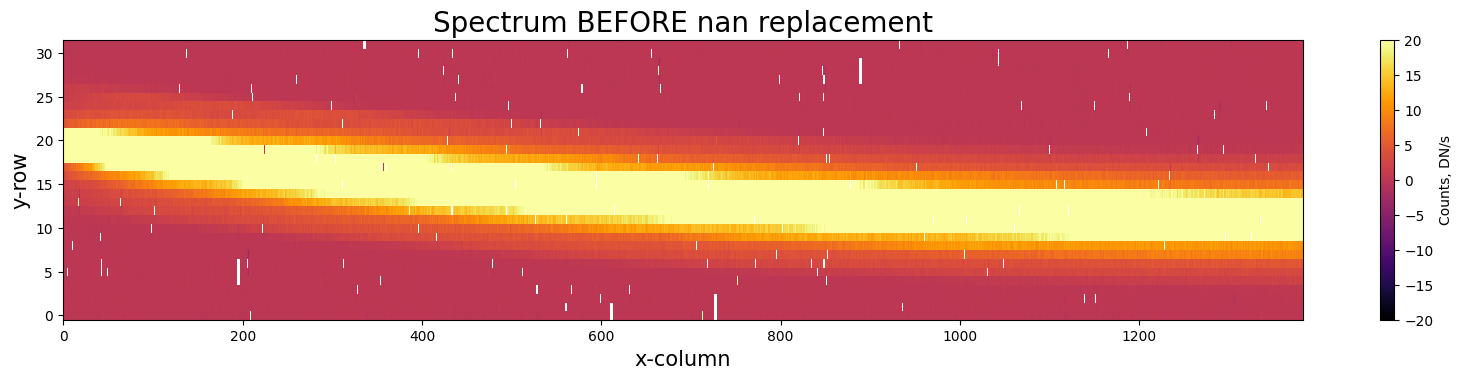

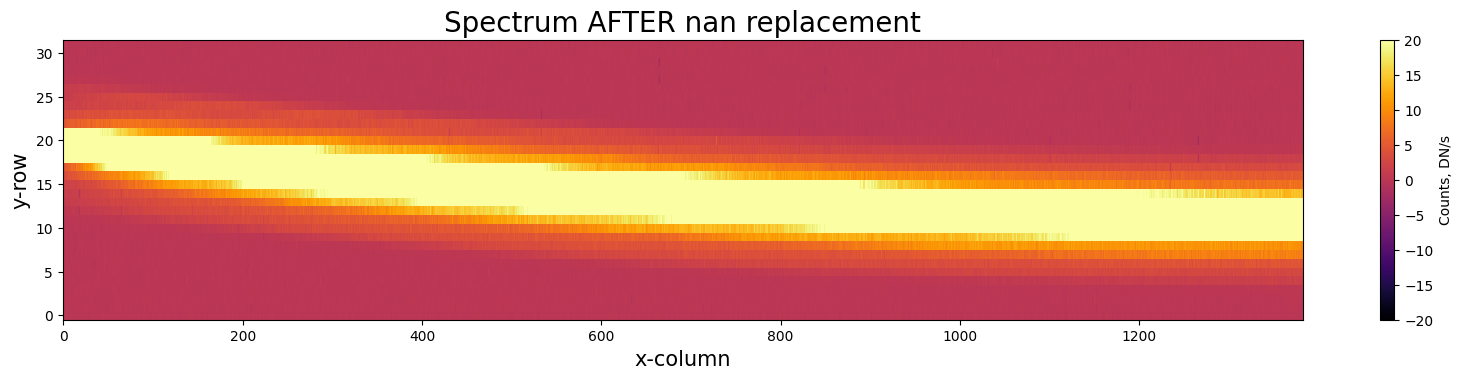

In [25]:

# Plot the image with replaced nans for inspection

if process_detector == 'nrs1':
    f_lo = -20 # lower limit for flux
    f_hi = +20 # upper limit for flux

if process_detector == 'nrs2':
    f_lo = -20 # lower limit for flux
    f_hi = +20 # upper limit for flux


if (nint <= 2):
    nshow = 0
else:
    nshow = 250


# First, plot an uncorrected 2D spectrum 

plt.figure(figsize=(20,8))
plt.subplot(211)


plt.title('Spectrum BEFORE nan replacement', fontsize=20)
im1 = plt.imshow(all_spec[nshow,:,:], 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower',
                 clim=(f_lo, f_hi))

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Counts, DN/s')



# Second, plot a corrected 2D spectrum 

plt.figure(figsize=(20,8))
plt.subplot(211)

plt.title('Spectrum AFTER nan replacement', fontsize=20)
im1 = plt.imshow(cor_all_spec[nshow,:,:], 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower',
                 clim=(f_lo, f_hi))

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Counts, DN/s')

plt.show()

In [26]:

# Pickle the corrected data, so we don't have to run it every time (this cells will execute if we run the notebook in 'process' mode)
if (run_mode == 'process'):
    
    print('\nSaving ' + process_detector + preprocessed_file_names[3] + '.')

    nominal_psf = {\
    'cor_all_spec':cor_all_spec, \
    'radius_edge_comb':radius_edge_comb \
    }
    
    pickle_out = open( spec2_results + '/' + process_detector + preprocessed_file_names[3], 'wb')
    pickle.dump(nominal_psf, pickle_out)
    pickle_out.close()

# <font color='white'>-</font>Step 5: Obtain centroid information using each 2D spectrum <a class="anchor" id="centroid"></a>

At this step, we will fit a Gaussian model to the spatial profile (column) of the 2d spectrum to determine where the spectrum is located for each column, and will obtain FWHM.

In [27]:
def get_spectral_centroid(image, dqflags, xstart, xend, plot_input_spec, title_in, plot_gauss, plot_trace):
    # Trace a spectrum (non-defocused)
    
    if plot_input_spec == 'yes':
        #Plot the median spectrum
        plt.figure(figsize=(10,2))
        plt.subplot(211)
        plt.title(title_in)

        im = plt.imshow(image, 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower',
                 clim=(f_lo, f_hi))

        plt.xlabel('X-column, pixel')
        plt.ylabel('Y-row, pixel')

        cb = plt.colorbar()
        cb.ax.set_ylabel('Rates (Counts/s)')

    
    # Prepare arrays that will save our results:
    x = np.arange(0, xend-xstart)
    y = np.zeros([xend-xstart])
    fwhm = np.zeros([xend-xstart])

    #Fit a Gaussian to the spectral profile of the median image    
    for j in range(len(image[0,:])-1):
        #print(j+1, ' out of ', len(image[0,:]))
        
        prof_yy = image[:,j]
        prof_xx = np.arange(len(prof_yy))

        idx_good = np.where((dqflags[:, j] == 0) & (~np.isnan(image[:, j])))[0]
        idx_bad = np.where((dqflags[:, j] != 0) & (np.isnan(image[:, j])))[0]
        
        #print(len(prof_xx), 'XX')
        #print(len(prof_yy), 'YY')

        #print(idx_good)
        
        #prof_xx = prof_xx[idx_good]
        #prof_yy = prof_yy[idx_good]

        prof_yy[np.isnan(prof_yy)] = 0.

        mean_yy = np.nanmean(prof_yy)
        std_yy = np.nanstd(prof_yy)
        
        ycen = np.mean(np.where(prof_yy >= mean_yy+2.0*std_yy)[0])
        #print(ycen)
        g_init = models.Gaussian1D(amplitude=np.nanmax(prof_yy), mean=ycen, stddev=2.)

        fit_g = fitting.LevMarLSQFitter()
        #print(len(prof_xx), len(prof_yy))
        g = fit_g(g_init, prof_xx, prof_yy)
        y[j] = g.mean.value
        fwhm[j] = g.stddev.value


        #Plot the best-fit Gaussian for one column
        if plt_gauss == 'yes':
            if j == 0:
                plt.figure(figsize=(5,5))
                plt.title("BFit Gauss to y-col")
                plt.plot(prof_xx, prof_yy, 'ko')
                plt.plot(prof_xx, g(prof_xx), label='Gaussian Fit')
                plt.xlabel('y-position, px')
                plt.ylabel('Flux, Counts/s')
                
    #Plot the measured trace for the median image
    if plt_trace == 'yes':
        plt.figure(figsize=(10,2))
        plt.subplot(211)
        plt.title(title_in+" and centroid (red line)")
        plt.xlabel('X-column, pixel')
        plt.ylabel('Y-row, pixel')
        fx_scale, fy_scale = 20, 8
        img_rescale = cv2.resize(image, (0, 0), fx=fx_scale, fy=fy_scale)
        #img_rescale = cv2.resize(image)
        im = plt.imshow(img_rescale, interpolation='None', aspect='auto', cmap='inferno', origin='lower', clim=(f_lo, f_hi))
        #im.set_clim(-3, 3)
        cb = plt.colorbar()
        cb.ax.set_ylabel('Rates (Counts/s)')
        plt.plot(fx_scale*x, fy_scale*y, color='red', lw=1, alpha=0.9)
        plt.show()
    return x, y, fwhm

This step takes about 13 and 18 minutes to run on NRS1 and NRS2, respectively.

In [28]:

# We will use the 1/f and nan-corrected data to perform our analysis
use_corrected_data = 'yes'

if (run_mode == 'process'):
    
    
    if (use_corrected_data == 'yes'):
        cp_2Dspec = np.copy(cor_all_spec)
    
    if (use_corrected_data == 'no'):
        cor_all_spec = np.copy(all_spec)
        cp_2Dspec = np.copy(all_spec)
    
    
    
    
    use_median = 'no' # yes/no
    
    if (use_median == 'yes'):
        # Compute a median combined spectrum
        #Compute a median image
        idx1 = 0
        idx2 = 20
        median_image = np.median(cp_2Dspec[idx1:idx2,:,:], axis=0)
    
        # Define parameters for the centroiding algorithm:
        xstart = 0                        #start of spectrum on the detector
        xend = len(median_image[0,0:])-0       # end of spectrum on the detector
        #print(xend)
    
        #ystart = 20 #define mid-line for tracing
        plot_input_spec = 'yes'
        title_in        = 'Median Image'
        plt_gauss       = 'yes'
        plt_trace       = 'yes'
    
        # Prepare arrays that will save our results:
        nintegrations = 1
        print(nintegrations)
    
        X1 = np.zeros([nintegrations, xend-xstart])
        Y1 = np.zeros([nintegrations, xend-xstart])
        FWHM1 = np.zeros([nintegrations, xend-xstart])
    
        # Obtain centroid information:
        for i in range(nintegrations):
            X1[i,:], Y1[i,:], FWHM1[i,:] = get_spectral_centroid(median_image, all_DQs[0,:,:], xstart, xend, plot_input_spec, title_in, plt_gauss, plt_trace )
    
    
    
    
    if (use_median == 'no'):
    
        # Define parameters for the centroiding algorithm:
        xstart = 0                        #start of spectrum on the detector
        xend = spec_xlen #len(median_image[0,0:])-0       # end of spectrum on the detector
        #print(xend)
    
        #ystart = 20 #define mid-line for tracing
        plot_input_spec = 'no'
        title_in        = 'Image'
        plt_gauss       = 'no'
        plt_trace       = 'no'
    
        # Prepare arrays that will save our results:
        nintegrations = nint# all_spec.shape[0]
        print(nintegrations)
    
        X1 = np.zeros([nintegrations, xend-xstart])
        Y1 = np.zeros([nintegrations, xend-xstart])
        FWHM1 = np.zeros([nintegrations, xend-xstart])
        #print(len(X1[:,0]), len(Y1[0,:]))
        
        # Let's time the step runtime
        start = tt.time()
        
        # Obtain centroid information:
        for i in tqdm(range(nintegrations)):
            X1[i,:], Y1[i,:], FWHM1[i,:] = get_spectral_centroid(cp_2Dspec[i,:,:], all_DQs[i,:,:], xstart, xend, plot_input_spec, title_in, plt_gauss, plt_trace )
            
        end = tt.time()
        print("Run time: ", round(end-start,1)/60.0, " min")


The arrays X1, Y1 and FWHM contain the centroid information for each integration. Instead of plotting them here, we will save them and use them later for the spectral tracing and to plot their median value for each image.

In [29]:

# Pickle the centroiding data along with the data, so we don't have to run it every time
if (run_mode == 'process'):
    
    print('\nSaving ' + process_detector + preprocessed_file_names[4] + '.')
    
    centroiding_data = {\
    'X1':X1, \
    'Y1':Y1, \
    'FWHM1':FWHM1 \
    }
    
    #if process_detector == 'nrs1':
    pickle_out = open( spec2_results + process_detector + preprocessed_file_names[4], 'wb')
    pickle.dump(centroiding_data, pickle_out)
    pickle_out.close()

In [30]:

# Restore the centroiding data
if (run_mode == 'load'):
    
    print('\nLoading ' + process_detector + preprocessed_file_names[4] + '.')
    
    pickle_in = open( spec2_results + '/' + process_detector + preprocessed_file_names[4], 'rb')
    
    centroiding_data = pickle.load( pickle_in )
    pickle_in.close() # close the file
    
    print('\nShowing the pickled data:')
    
    cnt = 0
    for item in centroiding_data:
        print('The data ', cnt, ' is : ', item)
        cnt += 1
    
    X1 = centroiding_data['X1']
    Y1 = centroiding_data['Y1']
    FWHM1 = centroiding_data['FWHM1']
    


Loading nrs1_step_05_centroiding.pickle.

Showing the pickled data:
The data  0  is :  X1
The data  1  is :  Y1
The data  2  is :  FWHM1


# <font color='white'>-</font>Step 6: Spectral tracing <a class="anchor" id="tracing"></a>

This step takes the centroiding data from the previous step and fits a polynomial to it to better locate the spectrum. The trace information is used to extract the spectra. 

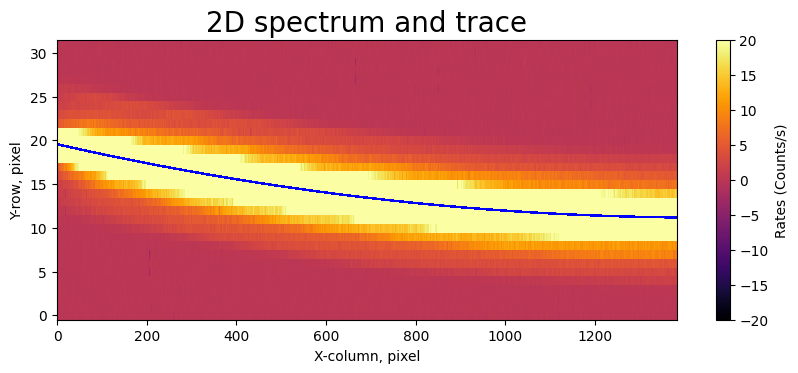

In [31]:
#Fit a Chebyshev polynomial to the centroid data
# Try orders from 1 to 30 in the polynomial for all the traces:
# Use the best-one as deemed by the BIC to fit all the traces; plot them with median image on top:


use_corrected_data = 'yes'

if (use_corrected_data == 'yes'):
    cp_2Dspec = np.copy(cor_all_spec)

if (use_corrected_data == 'no'):
    cp_2Dspec = np.copy(all_spec)



nintegrations = cp_2Dspec.shape[0]

plt.figure(figsize=(10,8))
plt.subplot(211)

im = plt.imshow(cp_2Dspec[150,:,:], 
         interpolation='None', 
         aspect='auto', 
         cmap='inferno', 
         origin='lower',
         clim=(f_lo, f_hi))

plt.xlabel('X-column, pixel')
plt.ylabel('Y-row, pixel')

cb = plt.colorbar()
cb.ax.set_ylabel('Rates (Counts/s)')

order = 2
coeffs1 = np.zeros([nintegrations, order+1])

SP_TRACE_X = 0.*np.copy(FWHM1)
SP_TRACE_Y = 0.*np.copy(FWHM1)

for i in range(nintegrations):
    # Fit only non-nans:
    x1_px = 10
    x2_px = len(Y1[0,:])-10
    idx = np.where(~np.isnan(Y1[i,x1_px:x2_px]))
    coeffs1[i,:] = chebyshev.chebfit(X1[i,x1_px:x2_px][idx], Y1[i,x1_px:x2_px][idx], deg=order)
    #plt.plot(X1[i,x1_px:x2_px], chebyshev.chebval(X1[i,x1_px:x2_px], coeffs1[i,:x2_px]), lw=1, color='blue')
    plt.plot(X1[i,:], chebyshev.chebval(X1[i,:], coeffs1[i,:]), lw=1, color='blue')
    plt.title('2D spectrum and trace', fontsize=20)
    SP_TRACE_X[i,:] = X1[i,:]
    SP_TRACE_Y[i,:] = chebyshev.chebval(X1[i,:], coeffs1[i,:])

plt.show()

OK, the spectral trace goes right in the middle of the spectrum.
Let's obtain median values for the FWHM and centroiding data using several pixel columns, and plot them as a function of time. Such data is sensistve to any changes in the conditions of the telescope and instrument during the observation.

465


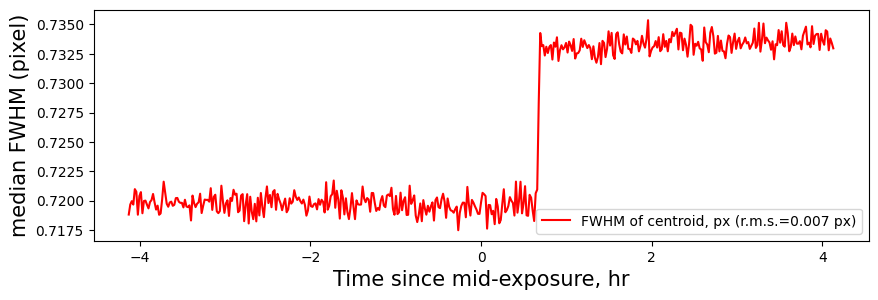

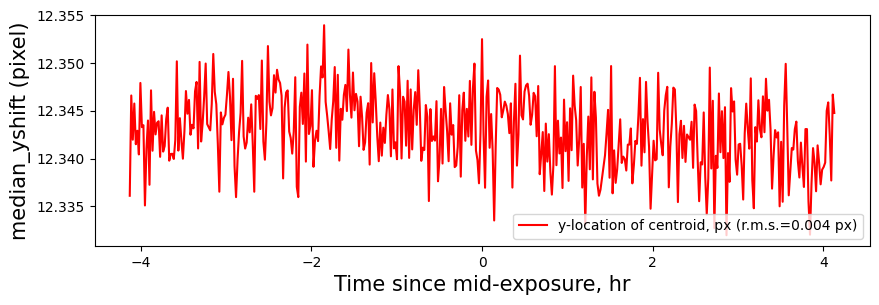

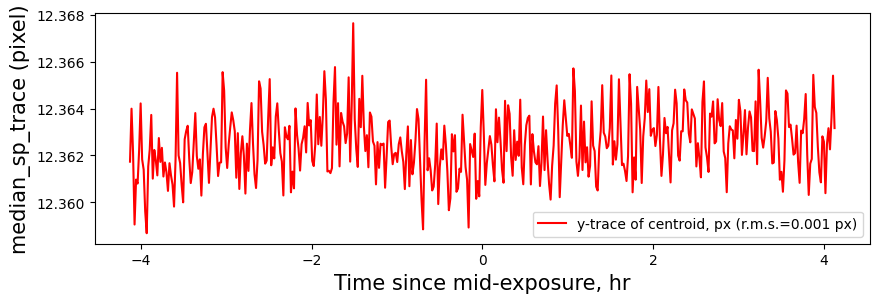

In [32]:
# compute median FWHM per spectrum
median_fwhm = np.zeros(nintegrations)
median_yshift = np.zeros(nintegrations)
median_sp_trace_y = np.zeros(nintegrations)

x_lo = 500
x_hi = 1300#spec_xlen - 10

print(nintegrations)

for i in range(nintegrations):
    median_fwhm[i] = np.nanmedian(FWHM1[i,x_lo:x_hi])
    median_yshift[i] = np.nanmedian(Y1[i,x_lo:x_hi])
    median_sp_trace_y[i] = np.nanmedian(SP_TRACE_Y[i,x_lo:x_hi])



plt.figure(figsize=(10, 3))
sigma_fwhm = np.sqrt(np.var(median_fwhm))
plt.plot((all_times-np.mean(all_times))*24., median_fwhm, color='red', label=f'FWHM of centroid, px (r.m.s.={round(sigma_fwhm, 3)} px)')
plt.legend(loc='lower right')
plt.xlabel('Time since mid-exposure, hr', fontsize=15)
plt.ylabel('median FWHM (pixel)', fontsize=15)
#plt.xlim([1, nintegrations])



plt.figure(figsize=(10, 3))
sigma_yshift = np.sqrt(np.var(median_yshift))
plt.plot((all_times-np.mean(all_times))*24., median_yshift, color='red', label=f'y-location of centroid, px (r.m.s.={round(sigma_yshift, 3)} px)')

plt.legend(loc='lower right')
plt.xlabel('Time since mid-exposure, hr', fontsize=15)
plt.ylabel('median_yshift (pixel)', fontsize=15)
#plt.xlim([1, nintegrations])



plt.figure(figsize=(10, 3))
sigma_ytrace = np.sqrt(np.var(median_sp_trace_y))
plt.plot((all_times-np.mean(all_times))*24., median_sp_trace_y, color='red', label=f'y-trace of centroid, px (r.m.s.={round(sigma_ytrace, 3)} px)')

plt.legend(loc='lower right')
plt.xlabel('Time since mid-exposure, hr', fontsize=15)
plt.ylabel('median_sp_trace (pixel)', fontsize=15)
#plt.xlim([1, nintegrations])

plt.show()

We clearly see a jump in the FWHM during the transit. Such abrupt changes are atributed to 'Tilt' events. The term 'Tilt' event refers to any un-commanded change of a primary mirror segment tilt and/or piston position. Such uncommanded changes can for instance be caused by micro-meteorites that encounter JWT primary mirror. For more details, please consult the following pages:

<a href="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#JWSTTimeSeriesObservationsNoiseSources-%22Tilt%22events">1. JWST Time-Series Observations Noise Sources</a>
<br>
<a href="https://jwst-docs.stsci.edu/jwst-observatory-characteristics/jwst-micrometeoroid-avoidance-zone">2. JWST Micrometeoroid Avoidance Zone</a>
<br>

In [33]:

# Pickle the trace data, so we don't have to run it every time
if (run_mode == 'process'):
    
    print('\nSaving ' + process_detector + preprocessed_file_names[5] + '.')
    
    spectral_trace = {\
    'SP_TRACE_X':SP_TRACE_X, \
    'SP_TRACE_Y':SP_TRACE_Y, \
    'coeffs1':coeffs1, \
    'order':order, \
    'median_fwhm':median_fwhm, \
    'median_yshift':median_yshift, \
    'median_sp_trace_y':median_sp_trace_y, \
    'x_lo':x_lo, \
    'x_hi':x_hi
    }
    
    #if process_detector == 'nrs1':
    pickle_out = open( spec2_results + process_detector + preprocessed_file_names[5], 'wb')
    pickle.dump(spectral_trace, pickle_out)
    pickle_out.close()

In [34]:


# Restore the spectral trace
if (run_mode == 'load'):
    
    print('\nLoading ' + process_detector + preprocessed_file_names[5] + '.')
    
    pickle_in = open( spec2_results + process_detector + preprocessed_file_names[5], 'rb')
    
    spectral_trace = pickle.load( pickle_in )
    pickle_in.close() # close the file
    
    print('Showing the pickled data:')
    
    cnt = 0
    for item in spectral_trace:
        print('The data ', cnt, ' is : ', item)
        cnt += 1
    
    SP_TRACE_X = spectral_trace['SP_TRACE_X']
    SP_TRACE_Y = spectral_trace['SP_TRACE_Y']
    coeffs1 = spectral_trace['coeffs1']
    order = spectral_trace['order']
    median_fwhm = spectral_trace['median_fwhm']
    median_yshift = spectral_trace['median_yshift']
    median_sp_trace_y = spectral_trace['median_sp_trace_y']
    x_lo = spectral_trace['x_lo']
    x_hi = spectral_trace['x_hi']


Loading nrs1_step_06_spectral_trace.pickle.
Showing the pickled data:
The data  0  is :  SP_TRACE_X
The data  1  is :  SP_TRACE_Y
The data  2  is :  coeffs1
The data  3  is :  order
The data  4  is :  median_fwhm
The data  5  is :  median_yshift
The data  6  is :  median_sp_trace_y
The data  7  is :  x_lo
The data  8  is :  x_hi


# <font color='white'>-</font>Step 7: Extract the spectra and obtain wavelength solution <a class="anchor" id="extraction"></a>

To obtain the light curves, we first need to extract one-dimensional spectra (1d) and assign wavelengths to each pixel. We will perform a simple aperture extraction using the trace information from the previous step. For each trace (in fact to each integer of the trace position) we will sum the flux from the corrected (for 1/f noise and replaced bad pixels) 2d spectra inside the aperture. 

With regards to the spectral background, we also define a background region for each column and use it to determine the median value. The median background is then subtracted from each column. We note that the 1/f step performed above does a very similar reduction of the background compared to this step of the aperture extraction. Since we already removed the 1/f noise, this step also removed the median background from each column. Therefore, in the aperture step below, we skip the background subtraction step. It is left at the discretion of the user to compare results with this step enabled.

The function below will perform the aperture extraction.

In [35]:
def aperture_extraction(image, x, y, aperture_radius, background_radius=15, error_image=None, correct_bkg=True):
    """
    This function takes as inputs two arrays (x,y) that follow the trace, 
    and returns the added flux over the defined aperture radius (and its error, if an error image 
    is given as well), substracting in the way any background between the aperture radius and the 
    background radius. The background is calculated by taking the median of the points between the 
    aperture_radius and the background_radius.
    
    Parameters
    ----------
    image: ndarray
        Image from which the spectrum wants to be extracted
    x: ndarray
        Array with the x-axis of the trace (i.e., the columns, wavelength direction)
    y: ndarray
        Array with the y-axis of the trace (i.e., rows, spatial direction)
    aperture_radius: float
        Distance from the center of the trace at which you want to add fluxes.
    background_radius: float
        Distance from the center of the trace from which you want to calculate the background. The 
        background region will be between this radius and the aperture_radius.
    error_image: ndarray
        Image with the errors of each pixel value on the image ndarray above
    correct_bkg: boolean
        If True, apply background correction. If false, ommit this.
    """
    #print(np.ndim(image), len(x))
    # Create array that will save our fluxes:
    flux = np.zeros(len(x))
    
    if error_image is not None:
        flux_error = np.zeros(len(x))
        
    max_column = image.shape[0]
    for i in range(len(x)):

        #print(int(x[i]))
        
        # Cut the column with which we'll be working with:
        #print( int(x[i]), len(image[:,2]))
        column = image[:,int(x[i])]
        if error_image is not None:
            variance_column = error_image[:,int(x[i])]**2
            
        # Define limits given by the aperture_radius and background_radius variables:
        if correct_bkg:
            left_side_bkg = np.max([y[i] - background_radius, 0])
            right_side_bkg = np.min([max_column, y[i] + background_radius])
        left_side_ap = np.max([y[i] - aperture_radius, 0])
        right_side_ap = np.min([max_column, y[i] + aperture_radius])
        
        # Extract background, being careful with edges:
        if correct_bkg:
            bkg_left = column[np.max([0, int(left_side_bkg)]) : np.max([0, int(left_side_ap)])]
            bkg_right = column[np.min([int(right_side_ap), max_column]) : np.max([int(right_side_bkg), max_column])]
            bkg = np.median(np.append(bkg_left, bkg_right))
        else:
            bkg = 0.
            
        # Substract it from the column:
        column -= bkg
        
        # Perform aperture extraction of the background-substracted column, being careful with pixelization 
        # at the edges. First, deal with left side:
        l_decimal, l_integer = np.modf(left_side_ap)
        l_integer = int(l_integer)
        if l_decimal < 0.5:
            l_fraction = (0.5 - l_decimal) * column[l_integer]
            l_limit = l_integer + 1
            if error_image is not None:
                l_fraction_variance = ((0.5 - l_decimal)**2) * variance_column[l_integer]
        else:
            l_fraction = (1. - (l_decimal - 0.5)) * column[l_integer + 1]
            l_limit = l_integer + 2
            if error_image is not None:
                l_fraction_variance = ((1. - (l_decimal - 0.5))**2) * variance_column[l_integer + 1]
                
        # Now right side:
        r_decimal, r_integer = np.modf(right_side_ap)
        r_integer = int(r_integer)
        if r_decimal < 0.5:
            r_fraction = (1. - (0.5 - r_decimal)) * column[r_integer]
            r_limit = r_integer
            if error_image is not None:
                r_fraction_variance = ((1. - (0.5 - r_decimal))**2) * variance_column[r_integer]
        else:
            r_fraction = (r_decimal - 0.5) * column[r_integer + 1]
            r_limit = r_integer + 1
            if error_image is not None:
                r_fraction_variance = ((r_decimal - 0.5)**2) * variance_column[r_integer + 1]
                
        # Save total flux in current column:
        flux[i] = l_fraction + r_fraction + np.sum(column[l_limit:r_limit])
        
        if error_image is not None:
            # For the flux error, ommit edge values (contribution to total variance is small nonetheless):
            flux_error[i] = np.sqrt(np.sum(variance_column[l_limit:r_limit]) + l_fraction_variance + \
                                    r_fraction_variance)
            
    if error_image is not None:
        return flux, flux_error
    else:
        return flux

Next, we just need to iterate over all of the 2d spectra and run the extraction function. This step is fast and takes only a few seconds.

100%|██████████| 465/465 [00:15<00:00, 29.70it/s]


Text(0, 0.5, 'Counts/s')

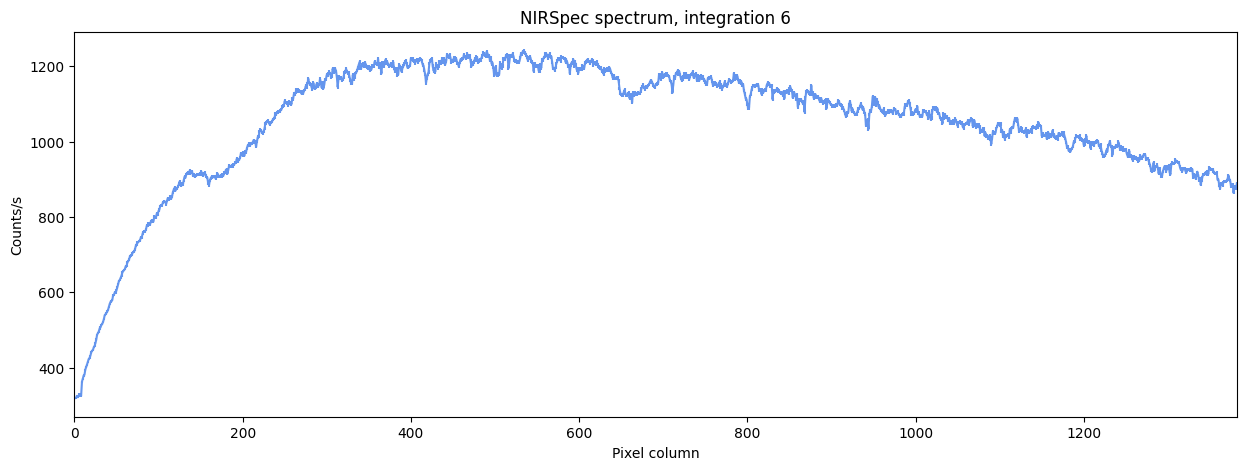

In [36]:
#Extract spectra 
use_corrected_data = 'yes'

if (use_corrected_data == 'yes'):
    cp_2Dspec = np.copy(cor_all_spec)

if (use_corrected_data == 'no'):
    cp_2Dspec = np.copy(all_spec)




# Extraction parameters:
if (process_detector == 'nrs1'):
    extraction_aperture =  3 #8#30 this is radius
    background_aperture = 10

if (process_detector == 'nrs2'):
    extraction_aperture =  5 #8#30 this is radius
    background_aperture = 10
    print(len(cp_2Dspec[0,0,:]), len(SP_TRACE_X[0,:]),len(SP_TRACE_Y[0,:]), len(all_err[0,0,:]) )
    
# Create dictionary:
spectra = {}
# Generate sub-dictionaries for each order:
spectra['order1'] = {}
# Save the X positions for both orders. X positions are the same for all integrations, so 
# we save the ones corresponding to the first integration:
spectra['order1']['x'] = X1[0,:]

# Create sub-dictionaries that will save the fluxes and the errors on those fluxes:
spectra['order1']['flux'] = np.zeros([cp_2Dspec.shape[0], len(X1[0,:])])
spectra['order1']['flux_errors']= np.zeros([cp_2Dspec.shape[0], len(X1[0,:])])

# Now iterate through all integrations:
for i in tqdm(range(nintegrations)):
    # Trace order 1:
    y1 = chebyshev.chebval(X1[0,:], coeffs1[i,:])
    # Extract order 1:
    #print(i, X1[i,2])
    spectra['order1']['flux'][i,:], spectra['order1']['flux_errors'][i,:] = \
                                                         aperture_extraction(cp_2Dspec[i,:,:], SP_TRACE_X[i,:], SP_TRACE_Y[i,:], 
                                                                             extraction_aperture, 
                                                                             error_image=all_err[i,:,:], 
                                                                             correct_bkg=False)

# Plot one extracted spectrum
i = 5
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('NIRSpec spectrum, integration ' + str(i+1))
ax.errorbar(spectra['order1']['x'], spectra['order1']['flux'][i,:], \
             yerr=spectra['order1']['flux_errors'][i,:], color='cornflowerblue')

ax.set_xlim(np.min(spectra['order1']['x']), np.max(spectra['order1']['x']))

ax.set_xlabel('Pixel column')
ax.set_ylabel('Counts/s')


In the next five lines print the first and last columns from the wavelength map for which the data values are not nans. 

[       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 2.77663407 2.77657534 2.77651661 2.77645786 2.7763991  2.77634033
 2.77628155 2.77622276 2.77616395 2.77610513 2.7760463  2.77598746
 2.77592861 2.77586975 2.77581087 2.77575198 2.77569308        nan
        nan        nan]
1383


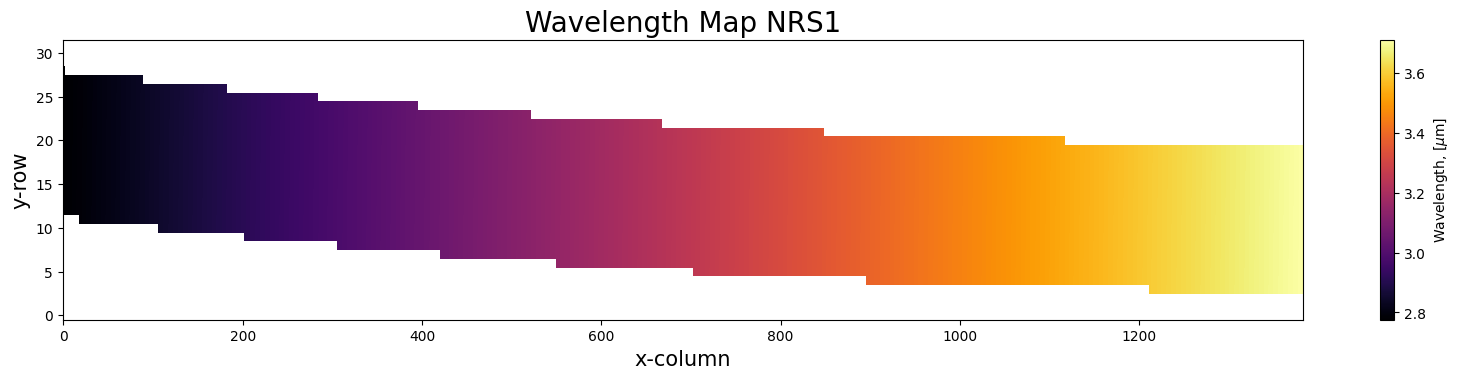

In [37]:

if (process_detector == 'nrs1'):
    print(wavelength_map[:,0])
    print(len(wavelength_map[4,:]))

if (process_detector == 'nrs2'):
    print(wavelength_map[:,2018])


plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('Wavelength Map ' + process_detector.upper(), fontsize=20)
im1 = plt.imshow(wavelength_map, 
                 interpolation='None', 
                 aspect='auto', 
                 cmap='inferno', 
                 origin='lower')

plt.xlabel('x-column', fontsize=15)
plt.ylabel('y-row', fontsize=15)

cb1 = plt.colorbar(label=r'Wavelength, [$\mu$m]')

plt.show()

In the next cell, we will define minimum and maximum pixel indexes, which we will use to trim the data to avoid the nans in the wavelength map. Next, we obtain the wavelength solution by iterating over each column and taking the median of wavelengths inside the aperture that was used earlier to extract the spectra. We will then plot again the spectrum to make sure everything looks good.

0.0
[1382]


Text(0, 0.5, 'Total flux in aperture, Counts/s')

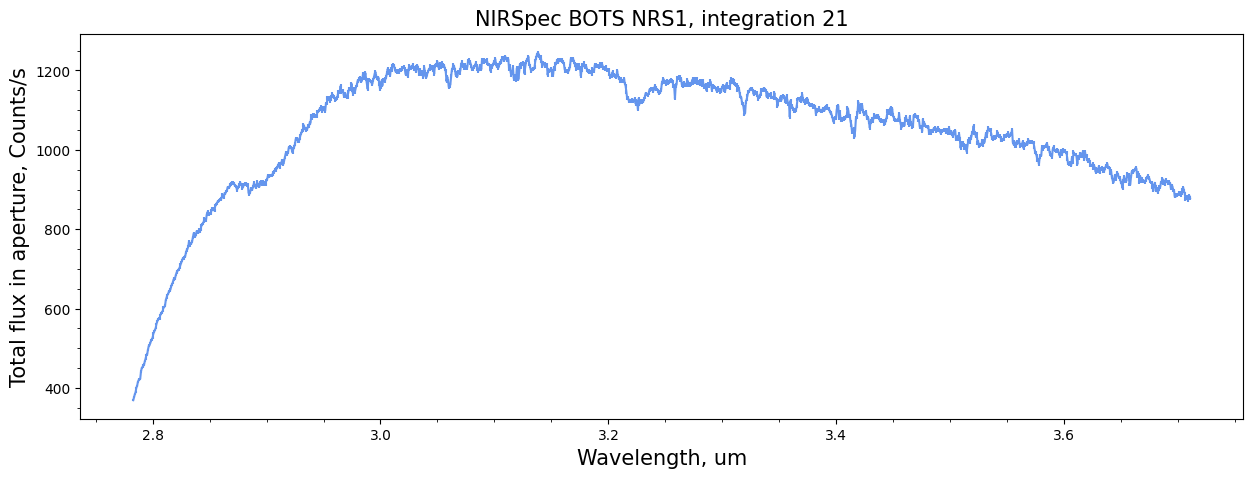

In [38]:
from matplotlib.ticker import AutoMinorLocator

spec_xlen = len(cp_2Dspec[0,0,:])
wave_um = np.zeros(spec_xlen)
#print(spec_xlen)

#print(len(wavelength_map[0,:]))
#print(len(wavelength_map[:,0]))
#print(len(wave_um))

# The wavelength map has some nans inside the spectral trace at the eadges. We romeve them by trimming these points.
if (process_detector == 'nrs1'):
    x11 = 10#126
    x22 = 1382

if (process_detector == 'nrs2'):
    x11 = 8
    x22 = 2018#len(all_spec[0,0,:]-2500)
    #print(len(all_spec[0,0,:]))

    
for i in range(spec_xlen-1):
    wave_um[i] = np.nanmedian(wavelength_map[ int(Y1[0,i])-extraction_aperture:int(Y1[0,i])+extraction_aperture, i])
    #print(i, int(Y1[0,i])-extraction_aperture, ' :', int(Y1[0,i])+extraction_aperture)
    #print(i, wave_um[i])

#print(wave_um)


print(np.nanmin(wave_um))
print( np.where(wave_um == np.nanmin(wave_um))[0] )

i = 20
fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title('NIRSpec BOTS '+process_detector.upper()+', integration ' + str(i+1), fontsize=15)
ax.errorbar(wave_um[x11:x22], spectra['order1']['flux'][i,x11:x22], yerr=spectra['order1']['flux_errors'][i,x11:x22], color='cornflowerblue')

# add minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

#ax.set_xlim(np.min(spectra['order1']['x']), np.max(spectra['order1']['x']))

ax.set_xlabel('Wavelength, um', fontsize=15)
ax.set_ylabel('Total flux in aperture, Counts/s', fontsize=15)



In [39]:
# Define an array for all 1D spectra
all_spec_1D = np.zeros([nintegrations, len(wave_um)])    
for i in range(nintegrations):        
    all_spec_1D[i,:] = spectra['order1']['flux'][i,:]


# get rid of the nans
wave_um = wave_um[x11:x22]
all_spec_1D = all_spec_1D[:, x11:x22]
FWHM1 = FWHM1[:, x11:x22]
X1 = X1[:, x11:x22]
Y1 = Y1[:, x11:x22]



In [40]:

# Pickle the extracted spectra, so we don't have to run this step every time
if (run_mode == 'process'):
    
    print('\nSaving ' + process_detector + preprocessed_file_names[6] + '.')
    
    spectra1D = {\
    'wave_um':wave_um, \
    'all_spec_1D':all_spec_1D
    }
    
    #if process_detector == 'nrs1':
    pickle_out = open( spec2_results + process_detector + preprocessed_file_names[6], 'wb')
    pickle.dump(spectra1D, pickle_out)
    pickle_out.close()

In [41]:


# Restore the extracted 1D spectra with wavelength solution
if (run_mode == 'load'):
    
    print('\nLoading ' + process_detector + preprocessed_file_names[6] + '.')
    
    pickle_in = open( spec2_results + process_detector + preprocessed_file_names[6], 'rb')
    
    spectra1D = pickle.load( pickle_in )
    pickle_in.close() # close the file
    
    print('Showing the pickled data:')
    
    cnt = 0
    for item in spectra1D:
        print('The data ', cnt, ' is : ', item)
        cnt += 1
    
    wave_um = spectra1D['wave_um']
    all_spec_1D = spectra1D['all_spec_1D']



Loading nrs1_step_07_spectra1D.pickle.
Showing the pickled data:
The data  0  is :  wave_um
The data  1  is :  all_spec_1D


# <font color='white'>-</font>Step 8: Produce white and spectroscopic light curves and fitting data <a class="anchor" id="lcs"></a>

With the extracted spectra and wavelength solution, we can now produce the white and spectroscopic light curves, as well as to check for wavelength dependence of the FWHM and spectroscopic light curves by the tilt event.

We will first produce the white light curve by summing the flux over the entire wavelength range.

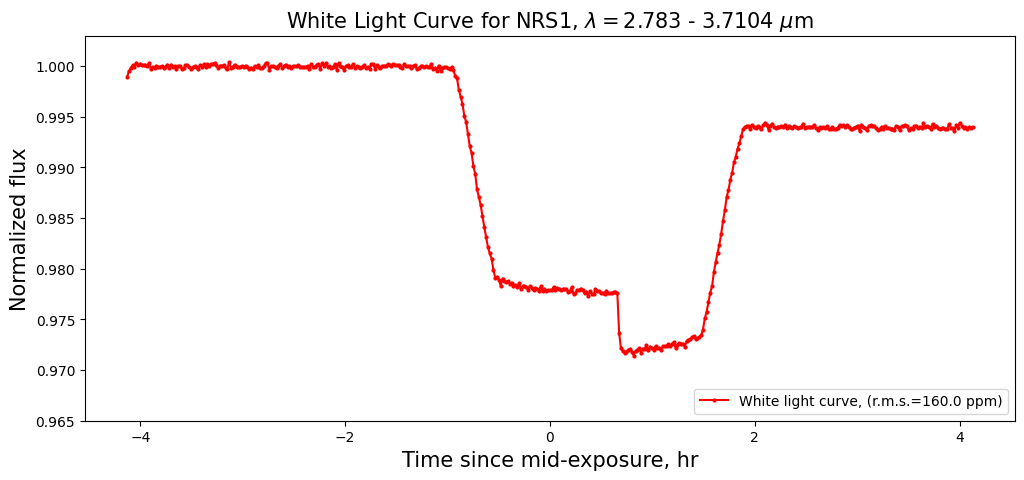

159.9901099989943


In [42]:
wlc_flux = np.zeros(nintegrations)

for i in range(nintegrations):
    wlc_flux[i] = np.sum(all_spec_1D[i,:])

# Normalize by the median flux of the first twenty points
wlc_flux /= np.median(wlc_flux[0:20])

plt.figure(figsize=(12, 5))
sigma_wlc = np.sqrt(np.nanvar(wlc_flux[2:100]))
plt.plot((all_times-np.nanmean(all_times))*24., wlc_flux, color='red', marker="o", markersize=2, label=f'White light curve, (r.m.s.={round(sigma_wlc*1e6, 0)} ppm)')
plt.legend(loc='lower right')
plt.title('White Light Curve for ' + process_detector.upper() + f', $\lambda=${round(wave_um[0], 4)} - {round(wave_um[len(wave_um)-1], 4)} $\mu$m', fontsize=15)
plt.xlabel('Time since mid-exposure, hr', fontsize=15)
plt.ylabel('Normalized flux', fontsize=15)
#plt.xlim([1, nintegrations])
plt.ylim([0.965,1.003])
#plt.xlim([-4.2,-0.5])

plt.show()

print(np.nanstd(wlc_flux[2:100])*1e6)

This light curve is of a very good quality with a scatter of just 162 ppm fir NRS1 in the first 100 data points.

Let's plot the FWHM for a few wavelengths and spectroscopic light curves, and see how the tilt event affects them. The function below will produce FWHM for a specific wavelength band from the data. It can also be used to produce chromatic (aka spectroscopic) light curves.

In [43]:
def obtain_time_series_for_wavelength(ts_2d_array, ts_wave_um, wave_cen_um, wave_radius_um):
    # Inputs: 
    # ts_data - two dimesional array of e.g., spectra, or FWHM, or centroid information for each integration of the time series
    # ts_wave_um - associated wavelength array; has the same number of elements as one of the dimensions of ts_data
    # wave_cen_um - wavelength at which we want to obtain the time series quantity 
    # wave_radius_um - wavelength search radius; indexes of wavelengths +/- the radius will be used to search for indeses 
    
    # determine the size of the ts_data 
    n_integrations = len(ts_2d_array[:,0])
    x_size = len(ts_2d_array[0,:])

    ts_vector_wave = np.zeros(n_integrations)

    # iterate over each integration, identify indexes at the needed wavelengths and compute median
    for i in range(n_integrations):
        idx1 = np.where((ts_wave_um >= wave_cen_um - wave_radius_um) & (ts_wave_um < wave_cen_um + wave_radius_um) )[0]
        if (len(idx1) == 0):
            print('No valid indexes in wavelength range!')
        else:
            #print(idx1)
            ts_vector_wave[i] = np.nanmedian(ts_2d_array[i,idx1])
    return ts_vector_wave

First, let's plot the spectroscopic light curves and inspect visually for any signs of discrepancy of the flux with wavelength.

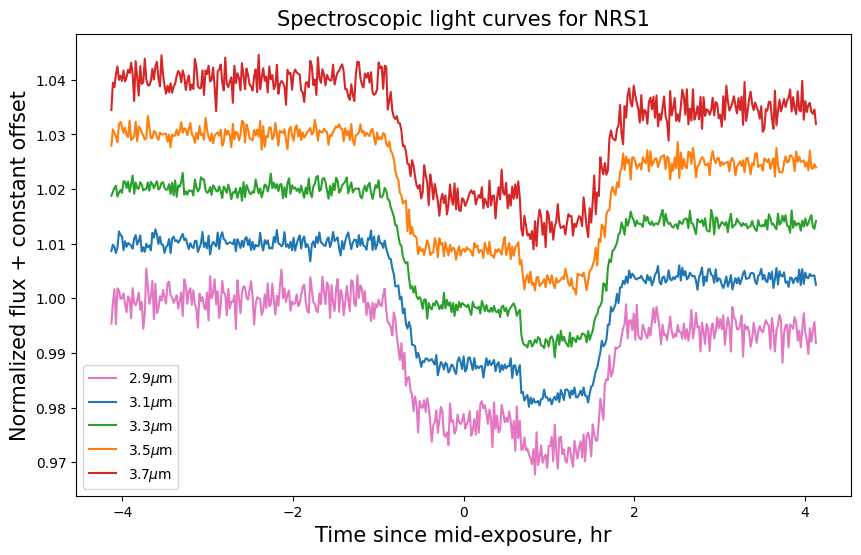

In [44]:

# define wavelength radius and central wavelengths
wave_radius_um = 0.025

if (process_detector == 'nrs1'):
    wave_center_um = np.array([2.9, 3.1, 3.3, 3.5, 3.7])
    wave_colors    = ['#E377C2', '#1F77B4', '#2CA02C', '#FF7F0E', '#D62728']

if (process_detector == 'nrs2'):
    wave_center_um = np.array([4.0, 4.2, 4.4, 4.6, 4.8])
    wave_colors    = ['#E377C2', '#1F77B4', '#2CA02C', '#FF7F0E', '#D62728']

plt.figure(figsize=(10, 6))

for i in range(len(wave_center_um)):
    #print(wave_center_um[i])
    lc_wav = obtain_time_series_for_wavelength(all_spec_1D, wave_um, wave_center_um[i], wave_radius_um)
    
    # normalize the light curve
    lc_wav /= np.nanmedian(lc_wav[0:100])
    
    plt.plot((all_times-np.mean(all_times))*24., lc_wav + 0.01*i, color=wave_colors[i], label=f'{str(wave_center_um[i])}$\mu$m')

plt.title('Spectroscopic light curves for ' + process_detector.upper(), fontsize=15)
plt.legend(loc='lower left')
plt.xlabel('Time since mid-exposure, hr', fontsize=15)
plt.ylabel('Normalized flux + constant offset', fontsize=15)

plt.show()

A visual inspection doesn't show an obvious discrepancy, besides the offset flux after array index 270. Let's renormalize the light curve after that index using the out of transit flux after the egress and check for offsets. 

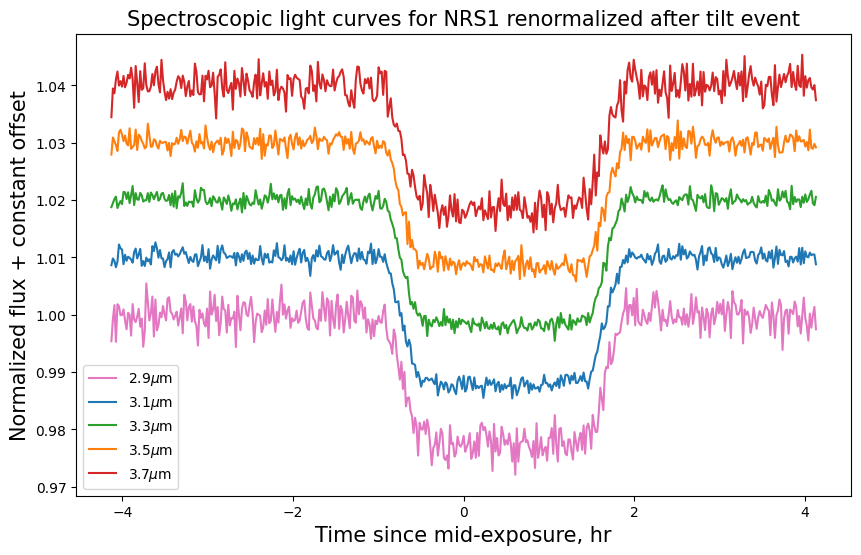

In [45]:

# define wavelength radius and central wavelengths
wave_radius_um = 0.025

idx_tilt = 270

if (process_detector == 'nrs1'):
    wave_center_um = np.array([2.9, 3.1, 3.3, 3.5, 3.7])
    wave_colors    = ['#E377C2', '#1F77B4', '#2CA02C', '#FF7F0E', '#D62728']

if (process_detector == 'nrs2'):
    wave_center_um = np.array([4.0, 4.2, 4.4, 4.6, 4.8])
    wave_colors    = ['#E377C2', '#1F77B4', '#2CA02C', '#FF7F0E', '#D62728']

plt.figure(figsize=(10, 6))

for i in range(len(wave_center_um)):
    #print(wave_center_um[i])
    lc_wav = obtain_time_series_for_wavelength(all_spec_1D, wave_um, wave_center_um[i], wave_radius_um)
    
    # normalize the light curve
    lc_wav /= np.nanmedian(lc_wav[0:100])

    # Correct for tilt event
    lc_wav[idx_tilt:] /= np.nanmedian(lc_wav[330:440])
    
    plt.plot((all_times-np.mean(all_times))*24., lc_wav + 0.01*i, color=wave_colors[i], label=f'{str(wave_center_um[i])}$\mu$m')

plt.title('Spectroscopic light curves for ' + process_detector.upper() + ' renormalized after tilt event', fontsize=15)
plt.legend(loc='lower left')
plt.xlabel('Time since mid-exposure, hr', fontsize=15)
plt.ylabel('Normalized flux + constant offset', fontsize=15)

plt.show()

Let's also plot differential light curves with respect to the light curve of the shortest wavelength.

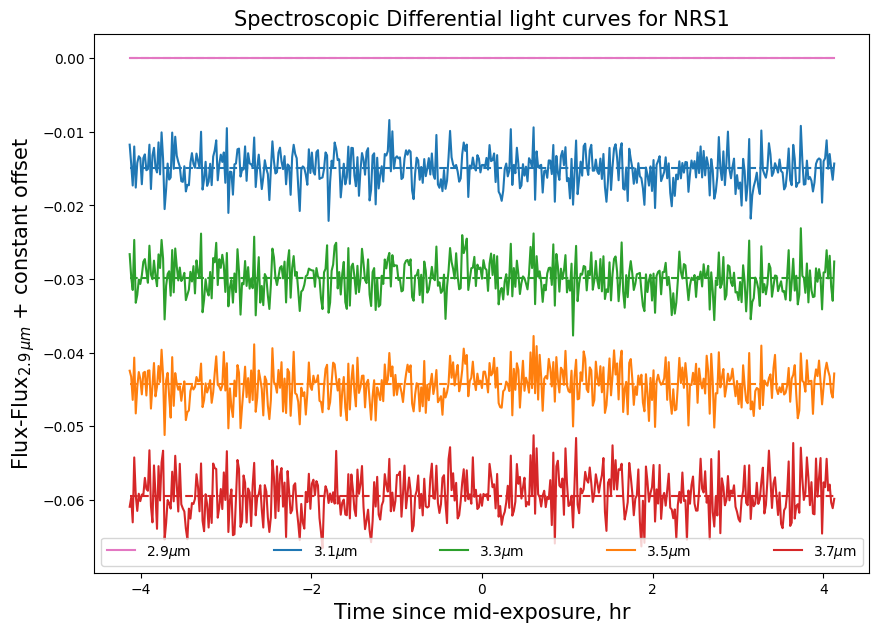

In [46]:

# define wavelength radius and central wavelengths
wave_radius_um = 0.025

if (process_detector == 'nrs1'):
    wave_center_um = np.array([2.9, 3.1, 3.3, 3.5, 3.7])
    wave_colors    = ['#E377C2', '#1F77B4', '#2CA02C', '#FF7F0E', '#D62728']

if (process_detector == 'nrs2'):
    wave_center_um = np.array([4.0, 4.2, 4.4, 4.6, 4.8])
    wave_colors    = ['#E377C2', '#1F77B4', '#2CA02C', '#FF7F0E', '#D62728']

plt.figure(figsize=(10, 7))

for i in range(len(wave_center_um)):
    #print(wave_center_um[i])
    lc_wav = obtain_time_series_for_wavelength(all_spec_1D, wave_um, wave_center_um[i], wave_radius_um)
    
    # normalize the light curve
    lc_wav /= np.nanmedian(lc_wav[0:100])

    if i == 0:
        ref_lc = lc_wav
    
    plt.plot((all_times-np.mean(all_times))*24., lc_wav - ref_lc - 0.015*i, color=wave_colors[i], label=f'{str(wave_center_um[i])}$\mu$m')
    plt.plot((all_times-np.mean(all_times))*24., np.median(lc_wav - ref_lc - 0.015*i)+0.*all_times, color=wave_colors[i], linestyle='dashed')
    


plt.title('Spectroscopic Differential light curves for ' + process_detector.upper(), fontsize=15)
plt.legend(loc='lower left', mode = 'expand', ncol = len(wave_center_um))
plt.xlabel('Time since mid-exposure, hr', fontsize=15)
plt.ylabel(r'Flux-Flux$_{2.9\,\mu m}$ + constant offset', fontsize=15)

plt.show()

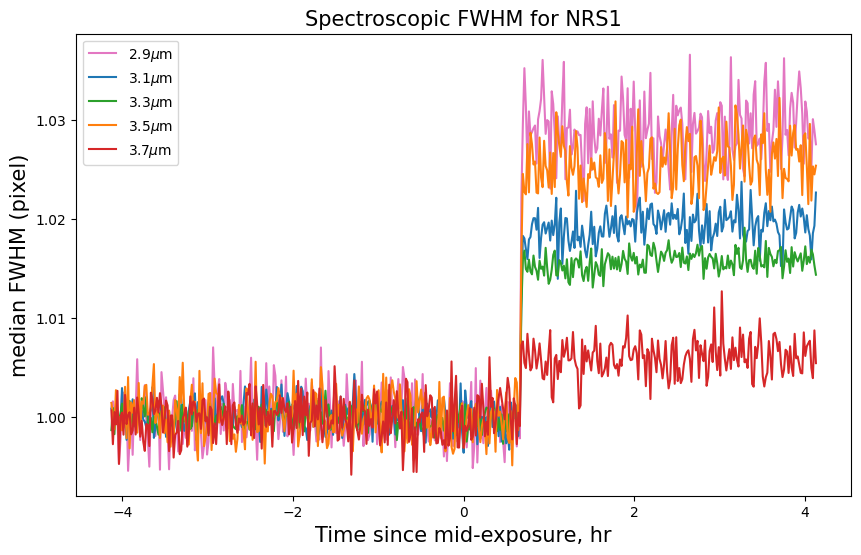

In [47]:

# define wavelength radius and central wavelengths
wave_radius_um = 0.025

if (process_detector == 'nrs1'):
    wave_center_um = np.array([2.9, 3.1, 3.3, 3.5, 3.7])
    wave_colors    = ['#E377C2', '#1F77B4', '#2CA02C', '#FF7F0E', '#D62728']

plt.figure(figsize=(10, 6))

for i in range(len(wave_center_um)):
    #print(wave_center_um[i])
    fwhm_wav = obtain_time_series_for_wavelength(FWHM1, wave_um, wave_center_um[i], wave_radius_um)
    
    # normalize the FWHM
    fwhm_wav /= np.nanmedian(fwhm_wav[0:100])
    
    plt.plot((all_times-np.mean(all_times))*24., fwhm_wav, color=wave_colors[i], label=f'{str(wave_center_um[i])}$\mu$m')


plt.title('Spectroscopic FWHM for ' + process_detector.upper(), fontsize=15)
plt.legend(loc='upper left')
plt.xlabel('Time since mid-exposure, hr', fontsize=15)
plt.ylabel('median FWHM (pixel)', fontsize=15)

plt.show()

First, the FWHM with wavelength

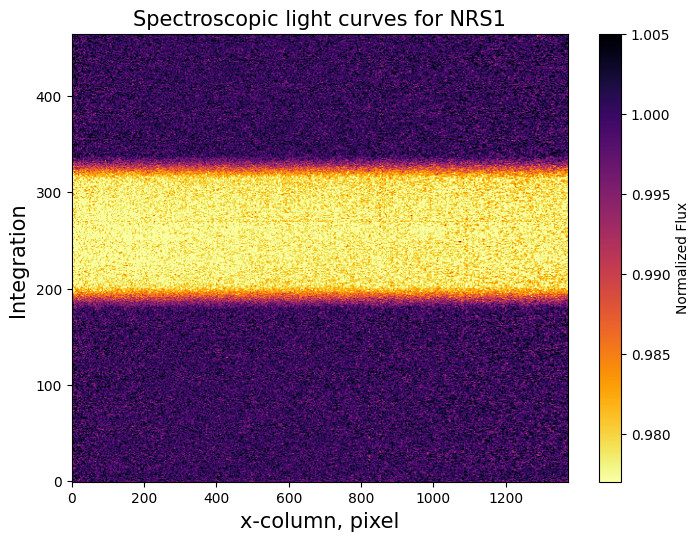

In [48]:
# Finally, plot chromatic light curves

lc_map = np.copy(all_spec_1D)
# 
spec_xlen = len(lc_map[0,:])


correct_tilt_event = 'yes'

for j in range(spec_xlen):
    # Normalize with each spectral line (removes throughput)
    lc_map[:,j] /= np.nanmean(lc_map[0:170,j])
    if correct_tilt_event == 'yes':
        # Correct for tilt event
        lc_map[270:,j] /= np.nanmean(lc_map[330:460,j])


mfactor = 1.6
plt.figure(figsize=(5*mfactor,8*mfactor))
plt.subplot(211)
plt.title('Spectroscopic light curves for ' + process_detector.upper(), fontsize=15)
im1 = plt.imshow(lc_map, 
                 interpolation='bilinear', 
                 aspect='auto', 
                 cmap='inferno_r', 
                 origin='lower', clim=(0.977, 1.005 ))

#plt.xlabel(r'Wavelength, $\mu$m', fontsize=15)
plt.xlabel(r'x-column, pixel', fontsize=15)
plt.ylabel('Integration ', fontsize=15)

# Suppress axis
#plt.axis('off')

#plt.axes()
#secax = axes().secondary_yaxis('right', functions=(RPRS_TO_H, H_TO_RPRS))
#secax.set_ylabel('Pressure scale height')

cb1 = plt.colorbar(label=r'Normalized Flux')

plt.show()

Save the light curves along with all fitting products to be ready for fitting.

In [49]:
print('\nSaving ' + process_detector + preprocessed_file_names[7] + '.')

light_curves = {\
'all_spec_1D':all_spec_1D, \
'wave_um':wave_um, \
'all_times':all_times, \
'wlc_flux':wlc_flux, \
'lc_map':lc_map, \
'median_fwhm':median_fwhm, \
'median_yshift':median_yshift, \
'X1':X1, \
'Y1':Y1, \
'FWHM1':FWHM1 \
}

#if process_detector == 'nrs1':
pickle_out = open( spec2_results + process_detector + preprocessed_file_names[7], 'wb')
pickle.dump(light_curves, pickle_out)
pickle_out.close()


Saving nrs1_step_08_light_curves.pickle.


### <font color='white'>-</font>5. Concluding remarks<a class="anchor" id="remarks"></a>

In this notebook, we demonstrated how to obtain light curves and fitting data products starting from the rateints files, and using a step from the JWST pipeline and our custom steps. The saved data producs can now be provided to light curve fitting codes for measurements of the physical properties of the exoplanet and obtaining a transmission spectrum. It should be pointed out that the analyses performed here are only a subset of the possible analyses one can perform, and are in no way the final word on _how_ JWST data _should_ be analyzed. This will be solidified more and more as data comes and best practices are established in the current and future cycles.

In conclusion, I would like to express my gratitude to the entire JWST team that has supported the creation of this notebook through discussions and testing, which have improved the notebook. In particular, special thanks to the Time-Series Observations Working Group at STScI, including Néstor Espinoza, Leonardo Ubeda, Sarah Kendrew, Elena Manjavacas, Brian Brooks, Mike Reagan, Loïc Albert, Everett Schlawin, Stephan Birkmann among others. To the NIRCam IDT team for multiple fruitful discussions, including Everett Schlawin, Thomas Beatty, Tom Greene and Jarron Leisenring. To the ERS Transiting Exoplanet team who have provided several venues for discussion and community input. To the several JWST team members, including behind the pipeline and the mission itself, including and in no particular order Bryan Hilbert, Armin Rest, Anton Koekemoer, Alicia Canipe, Melanie Clarke, James Muzerolle, Kayli Glidic, Jeff Valenti and Karl Gordon. 